## Objective
The objective of the project is train a model using complicated datasets. This challenge stood out for me than the others as it was a good opportunity to go beyond the traditional ML models to explore CNN and NLP.

For the selected project, the goals are to:
- Explore the different datasets and see how features affect the model
- Build insights and visualisations to support findings
- Build a model to predict adoption speed of pets

## Introduction

The datasets are gotten from Malaysia's [petfinder.my](https://www.petfinder.my/), which is not only a pet adoption website that give details of lots of pets but also show listings of lost pets etc. We will be focusing on the adoption bit.

This project will explore these dataset and then build a model to predict adoption speed using CNN, NLP and boosting techniques 

In [2]:
import numpy as np 
import pandas as pd 
import os
import json
import seaborn as sns 
import cv2 
import matplotlib.pyplot as plt
import glob
import time
from wordcloud import WordCloud
from scipy import stats
import xgboost as xgb
mport gc
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import cohen_kappa_score 
from tabulate import tabulate
from tqdm import tqdm_notebook
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from sklearn.cluster import KMeans



%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
#pd.set_option('display.max_colwidth', -1)

In [3]:
# Loading the datasets
colors = pd.read_csv('color_labels.csv')
breeds = pd.read_csv('breed_labels.csv')
states = pd.read_csv('state_labels.csv')

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test/test.csv')


train_images_path = ('train_images')
test_images_path = ('test_images')



## Exploratory Data Analysis

In [4]:
print(train_df.dtypes)

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [6]:
train_df.describe()

Type           Age        Breed1        Breed2        Gender  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.457614     10.452078    265.272594     74.009738      1.776162   
std        0.498217     18.155790     60.056818    123.011575      0.681592   
min        1.000000      0.000000      0.000000      0.000000      1.000000   
25%        1.000000      2.000000    265.000000      0.000000      1.000000   
50%        1.000000      3.000000    266.000000      0.000000      2.000000   
75%        2.000000     12.000000    307.000000    179.000000      2.000000   
max        2.000000    255.000000    307.000000    307.000000      3.000000   

             Color1        Color2        Color3  MaturitySize     FurLength  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       2.234176      3.222837      1.882012      1.862002      1.467485   
std        1.745225      2.742562      2.984086      0.547959      0.599070   
min        1.000000      0.000000      0.000000      1.000000      1.000000   
25%        1.000000      0.000000      0.000000      2.000000      1.000000   
50%        2.000000      2.000000      0.000000      2.000000      1.000000   
75%        3.000000      6.000000      5.000000      2.000000      2.000000   
max        7.000000      7.000000      7.000000      4.000000      3.000000   

         Vaccinated      Dewormed    Sterilized        Health      Quantity  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.731208      1.558727      1.914227      1.036617      1.576069   
std        0.667649      0.695817      0.566172      0.199535      1.472477   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        1.000000      1.000000      2.000000      1.000000      1.000000   
50%        2.000000      1.000000      2.000000      1.000000      1.000000   
75%        2.000000      2.000000      2.000000      1.000000      1.000000   
max        3.000000      3.000000      3.000000      3.000000     20.000000   

                Fee         State      VideoAmt      PhotoAmt  AdoptionSpeed  
count  14993.000000  14993.000000  14993.000000  14993.000000   14993.000000  
mean      21.259988  41346.028347      0.056760      3.889215       2.516441  
std       78.414548     32.444153      0.346185      3.487810       1.177265  
min        0.000000  41324.000000      0.000000      0.000000       0.000000  
25%        0.000000  41326.000000      0.000000      2.000000       2.000000  
50%        0.000000  41326.000000      0.000000      3.000000       2.000000  
75%        0.000000  41401.000000      0.000000      5.000000       4.000000  
max     3000.000000  41415.000000      8.000000     30.000000       4.000000

#### Train data Overview
- The dataset consists of 14993 observations and 24 variables.
- The 'Type' column represents the types of pets in the dataset, where Dogs = 1 and Cats = 2. 
- For AdoptionSpeed:
    The values of that column were categorized into 5 time slices.

    0 - Pet was adopted on the same day as it was listed.

    1 - Pet was adopted between 1 and 7 days (1st week) after being listed.

    2 - Pet was adopted between 8 and 30 days (1st month) after being listed.

    3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.

    4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).
    
- Most features, even though numerical, represents a category, hence it may not be necessary to talk about outliers.



### Univariate Analysis

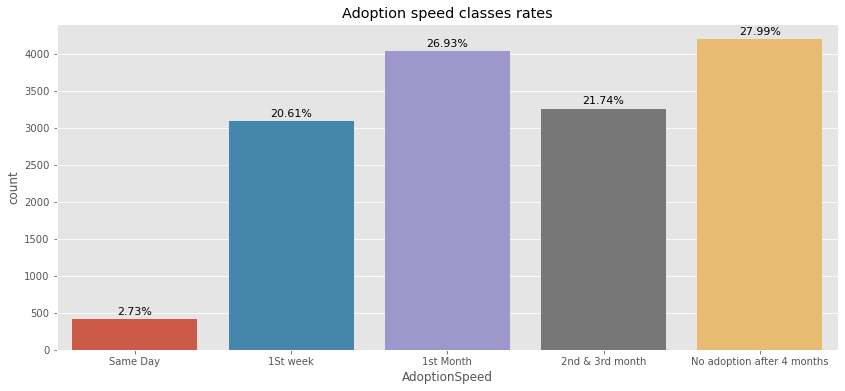

In [7]:
# exploring the target variables
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=train_df)
plt.title('Adoption speed classes rates');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train_df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 8),
         textcoords='offset points')  
ax=ax.set_xticklabels(['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption after 4 months'])

We can see that 28% of the pets werent adopted after 100 Days, that means 72% of the pets were adopted before 100 days.

Let's look at the correlation between features and the adoption speed. We will refer to adoption before 100 days as 0 and adoption after 100 days as 1, to make the visuals neat and easy.

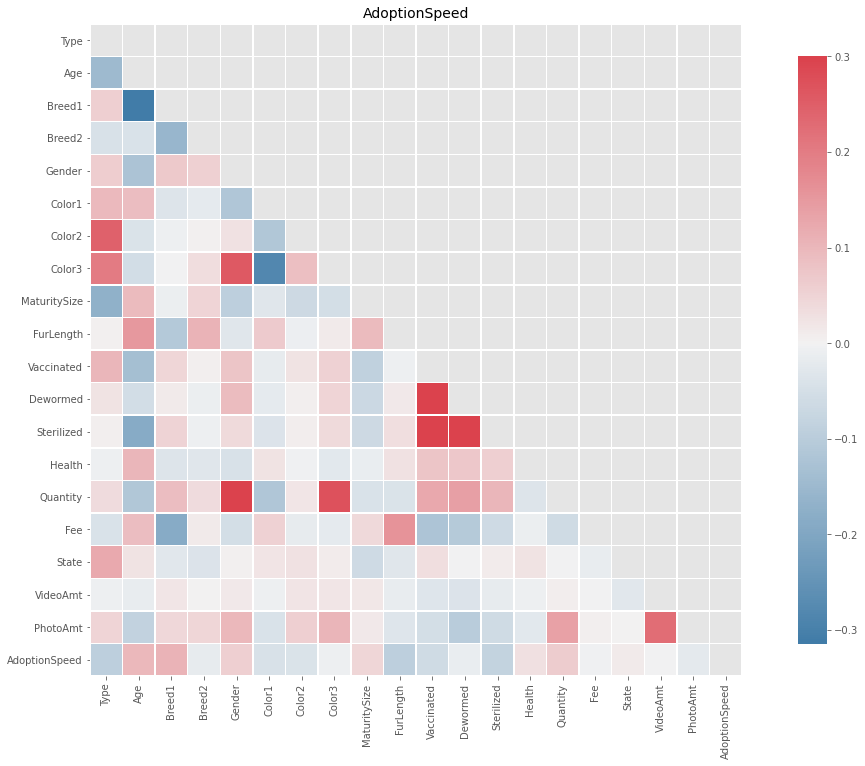

In [8]:
adopted_df=train_df.copy()
adopted_df['AdoptionSpeed'].replace(
    to_replace=[ 0, 1, 2 ,3 ],
    value=0,
    inplace=True
)
adopted_df['AdoptionSpeed'].replace(
    to_replace=[ 4 ],
    value=1,
    inplace=True
)

f, ax1 = plt.subplots(1,1,figsize=(20,12))

corr=train_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(240, 10, as_cmap=True,n=9)

ax1=sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5,vmax=0.3, cbar_kws={"shrink": .9})
ax1.set_title("AdoptionSpeed",fontsize=14);

There are some relationships that can be seen among the features.

We will explore further to confirm some of these relationships.

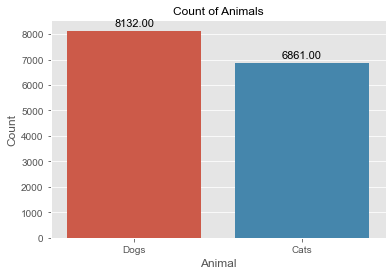

In [9]:
ax = sns.countplot(x="Type", data=train_df)
sns.set(font_scale=1.0)
ax.set(xlabel = 'Animal', ylabel = 'Count')
ax.set_xticklabels(["Dogs","Cats"])
ax.set_title('Count of Animals')
for i,p in enumerate(ax.patches):
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-80),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')

There are more Dogs than Cats in the dataset.

### Bivariate Analysis

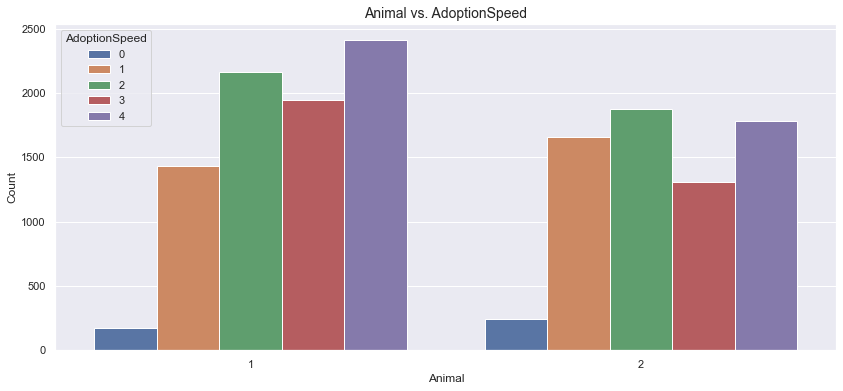

In [10]:
sns.set(font_scale=1.0)
plt.figure(figsize=(14, 6));
ax = sns.countplot(x='Type',hue='AdoptionSpeed',data=train_df)
ax.set_title("Animal vs. AdoptionSpeed",fontsize=14);
ax.set(xlabel = 'Animal', ylabel = 'Count');

Cats are adopted more on the same day than Dogs. But generally, Dogs are adopted faster than Cats. 

Let's see if a pet been named or not has any effect on the adoption speed.

In [11]:
train_df.Name.value_counts()

Baby                              66
Lucky                             64
No Name                           54
Brownie                           54
Mimi                              52
                                  ..
Bravie Babies                      1
Boiboi                             1
Bright                             1
KITTENS:Om, Cupid, Lucid, Yoda     1
Max & Molly                        1
Name: Name, Length: 9060, dtype: int64

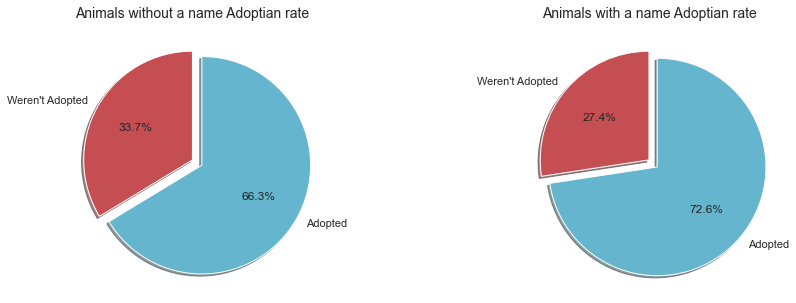

In [12]:
train_df['Name'] =train_df['Name'].fillna('NULL')

no_name_df=train_df.copy() #df without any names
no_name_df['Name']=no_name_df['Name'].replace({"No Name": "NULL", "No Name Yet": "NULL", "Unknown": "NULL", "Baby": "NULL","Lucky": "NULL","Brownie": "NULL","Blackie": "NULL","Puppy": "NULL","Kitty": "NULL","Kittens":"NULL"})
no_name_df= no_name_df[no_name_df['Name']=='NULL']

no_name_df['Name'].value_counts()

adopted_no_name=no_name_df[no_name_df['AdoptionSpeed']<=3]
count_adopted_no_name=adopted_no_name.count()[1]
adopted_no_name_percent=count_adopted_no_name/no_name_df.count()[1]

named_df=train_df.copy() # df with all the names
named_df.drop(named_df.index[named_df['Name'] == "NULL"], inplace = True)
adopted_named=named_df[named_df['AdoptionSpeed']<=3]
count_adopted_named=adopted_named.count()[1]
adopted_named_percent=count_adopted_named/named_df.count()[1]

fig1, ax1 = plt.subplots(1,2,figsize=(15,5))
explode = (0, 0.1)
labels = "Weren't Adopted" ,'Adopted'
ax1[0].set_title("Animals without a name Adoptian rate",fontsize=14)
ax1[0].pie([no_name_df.count()[1]-count_adopted_no_name,count_adopted_no_name], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=['C3','C9'])

ax1[1].set_title("Animals with a name Adoptian rate",fontsize=14)
ax1[1].pie([named_df.count()[1]-count_adopted_named,count_adopted_named], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=['C3','C9'])


plt.show()

We can see that the pets with a name were adopted more than pets without a name.

How does age of pet affect the adoption speed?

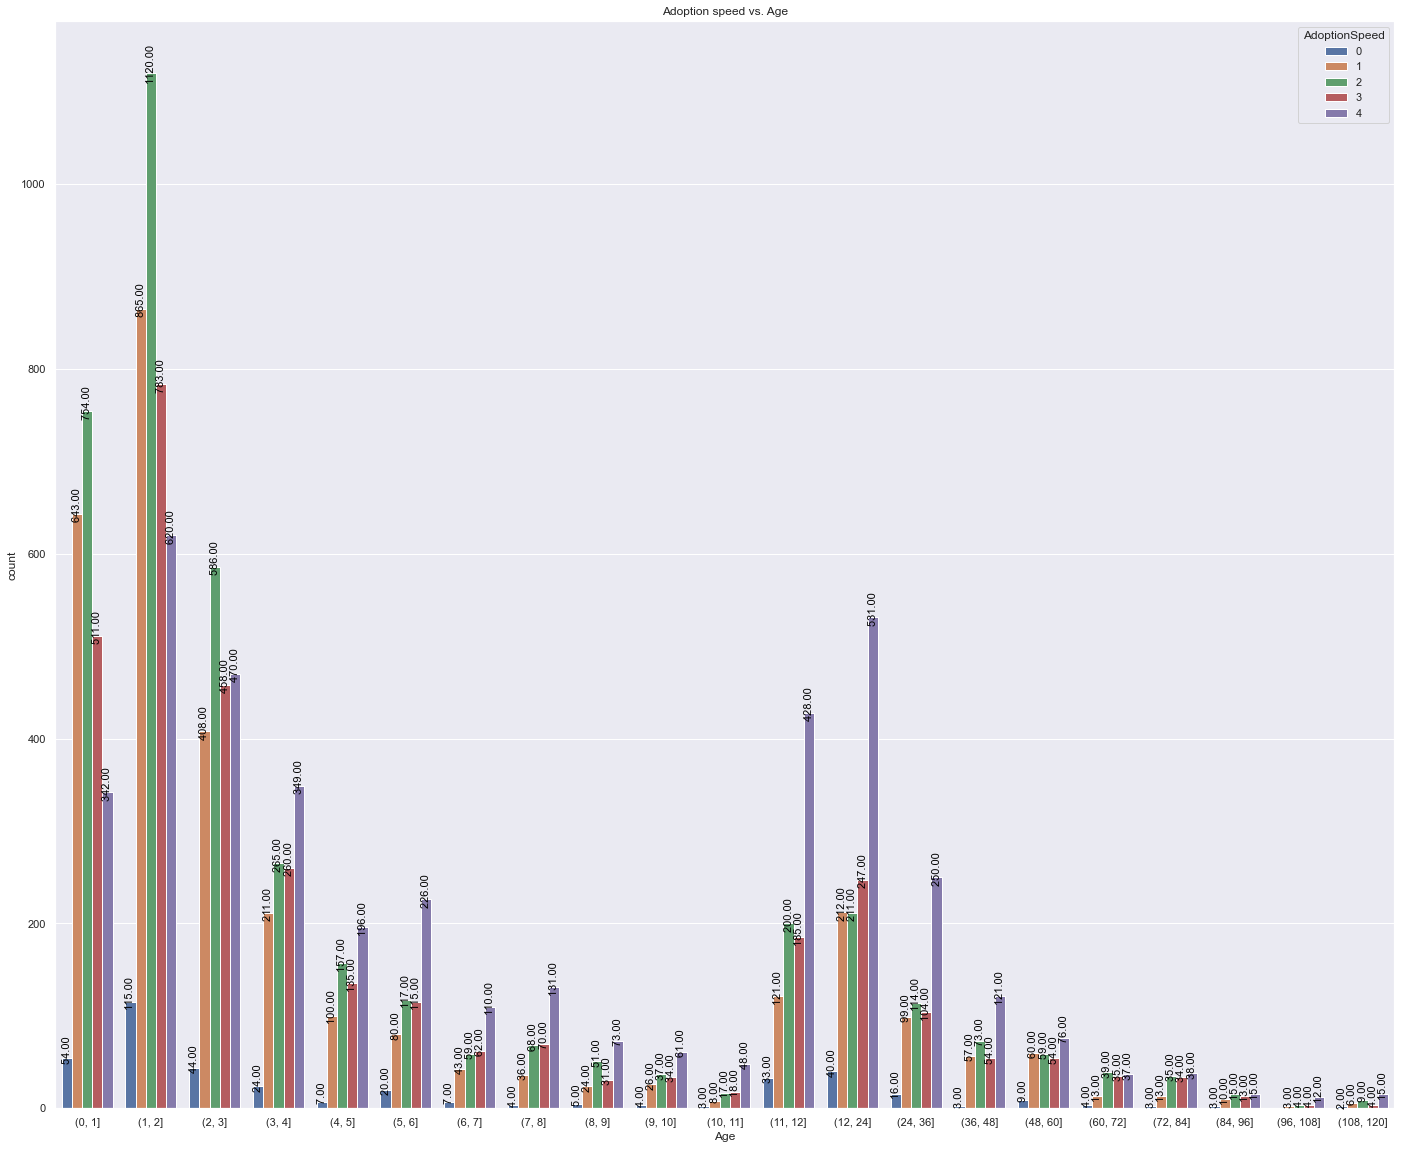

In [13]:
age_df=train_df.copy()

age_df.drop(age_df[age_df['Age'] >121].index, inplace=True)
plt.figure(figsize=(24, 20));

bins =[i  for i in range(0,13)]
for i in range(2,11):
    bins.append(i*12)

age_df['Age'] = pd.cut(age_df['Age'], bins)
ax=sns.countplot(x='Age',hue='AdoptionSpeed',data=age_df)
ax.set_title('Adoption speed vs. Age')
for i,p in enumerate(ax.patches):
    
    ax.annotate("%.2f " % (p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=90, xytext=(0, 10),
         textcoords='offset points') 

/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

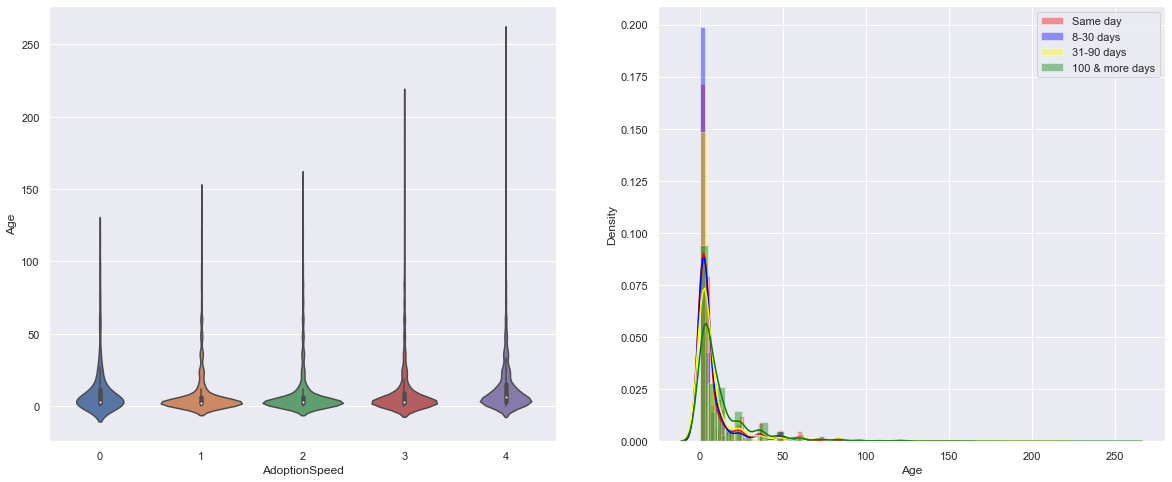

In [14]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'AdoptionSpeed', y = 'Age', data = train_df)

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['AdoptionSpeed'] == 1]['Age'], label = "Same day", color = 'red')
sns.distplot(train_df[train_df['AdoptionSpeed'] == 2]['Age'], label = "8-30 days" , color = 'blue' )
sns.distplot(train_df[train_df['AdoptionSpeed'] == 3]['Age'], label = "31-90 days" , color = 'yellow' )
sns.distplot(train_df[train_df['AdoptionSpeed'] == 4]['Age'], label = "100 & more days" , color = 'green' )

plt.legend()
plt.show();


- We can see that the age has an effect to the adoption speed as the younger pets are adopted more quickly than the older pets.

- Also, for the dist plot, we can see high overlapping, not withstanding there is an indication that Age is an important feature as the older the pets get the less likely they are to be adopted.

Let's investigate our breeds

In [15]:
print(breeds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   BreedID    307 non-null    int64 
 1   Type       307 non-null    int64 
 2   BreedName  307 non-null    object
dtypes: int64(2), object(1)
memory usage: 7.3+ KB
None


In [16]:
breeds.head()

BreedID  Type         BreedName
0        1     1     Affenpinscher
1        2     1      Afghan Hound
2        3     1  Airedale Terrier
3        4     1            Akbash
4        5     1             Akita

In [17]:
print(train_df[train_df['Type']==1]['Breed1'].value_counts())
print(train_df[train_df['Type']==2]['Breed1'].value_counts())

307    5923
141     205
205     189
179     167
218     161
       ... 
93        1
85        1
81        1
25        1
99        1
Name: Breed1, Length: 116, dtype: int64
266    3634
265    1258
299     342
264     296
292     264
       ... 
218       1
114       1
257       1
70        1
0         1
Name: Breed1, Length: 68, dtype: int64


We have 307 different breeds for dogs and cats in total. Investigated why some breeds have such high numbers and found out we have some "Mixed" Breeds labels

We will group them into categories

In [18]:
dog_mixed_breed_df=train_df[(train_df['Breed1']==307)& (train_df['Type']== 1)]
dog_mixed_breed_df['Breed1']='Mixed Dogs'

dog_pure_breed_df=train_df[(train_df['Breed1']!=307) & (train_df['Type']== 1)]
dog_pure_breed_df['Breed1']='PureDogs'

cat_pure_breed_df=train_df[(train_df['Breed1']!=266) & (train_df['Breed1']!=265) & (train_df['Breed1']!=264) & (train_df['Type']== 2)] 
cat_pure_breed_df['Breed1']='PureCats'

cat_short_hair_df=train_df[(train_df['Breed1']==266) & (train_df['Type']== 2)]
cat_short_hair_df['Breed1']='Domestic Short Hair Cats'

cat_medium_hair_df=train_df[(train_df['Breed1']==265) & (train_df['Type']== 2)]
cat_medium_hair_df['Breed1']='Domestic Medium Hair Cats'

cat_long_hair_df=train_df[(train_df['Breed1']==264) & (train_df['Type']== 2)]
cat_long_hair_df['Breed1']='Domestic Long Hair Cats'


breeds_df = dog_mixed_breed_df.copy()
breeds_df = breeds_df.append(dog_pure_breed_df)
breeds_df = breeds_df.append(cat_pure_breed_df)
breeds_df = breeds_df.append(cat_short_hair_df)
breeds_df = breeds_df.append(cat_medium_hair_df)
breeds_df = breeds_df.append(cat_long_hair_df)


breeds_adopted_df=breeds_df[breeds_df['AdoptionSpeed']<=3]
breeds_percentage=breeds_adopted_df['Breed1'].value_counts()/breeds_df['Breed1'].value_counts()

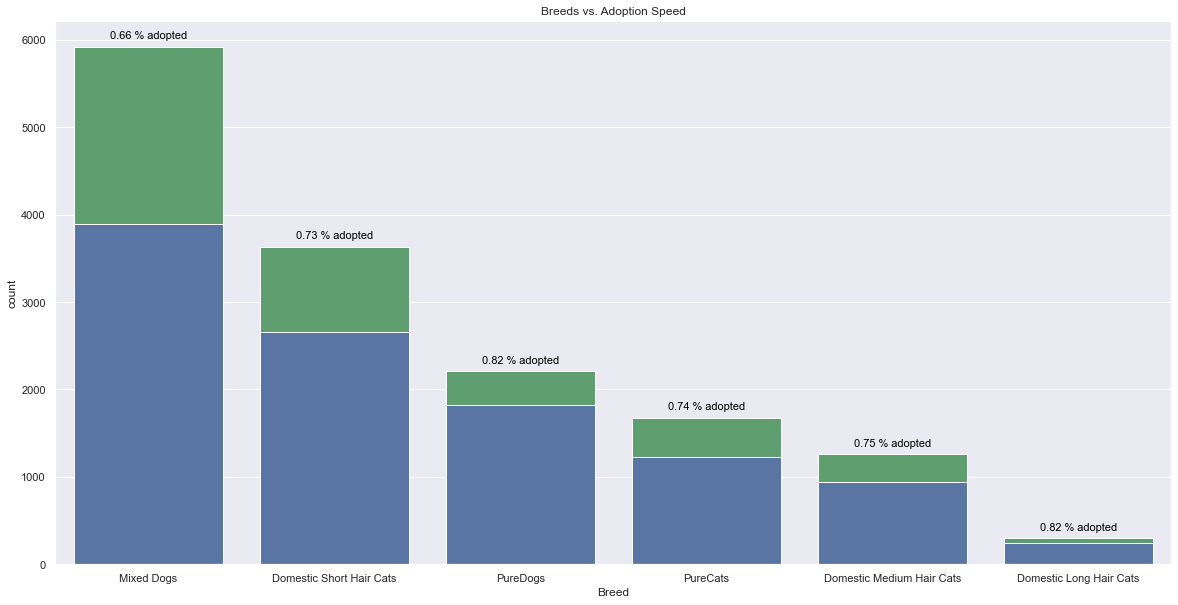

In [19]:
plt.figure(figsize=(20, 10));

ax=sns.countplot(x="Breed1", data=breeds_df,color='g',order = breeds_df['Breed1'].value_counts().index)
for i,p in enumerate(ax.patches):
    
    ax.annotate("%.2f %% adopted" % breeds_percentage[i] , (p.get_x() + p.get_width() / 2., p.get_height()-100),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')

ax.set_title('Breeds vs. Adoption Speed')  
ax=sns.countplot(x="Breed1", data=breeds_adopted_df,color='b',order = breeds_df['Breed1'].value_counts().index)
plt.xlabel('Breed');

From the graph, we can see that PureDogs and Domestic Long Hair Cats are adopted more.

There is a 16% difference in Adoptation percentage between Pure Dogs and Mixed Dogs


Let's see if gender affects adoption speed

In [20]:
train_df['Gender'].value_counts()

2    7277
1    5536
3    2180
Name: Gender, dtype: int64

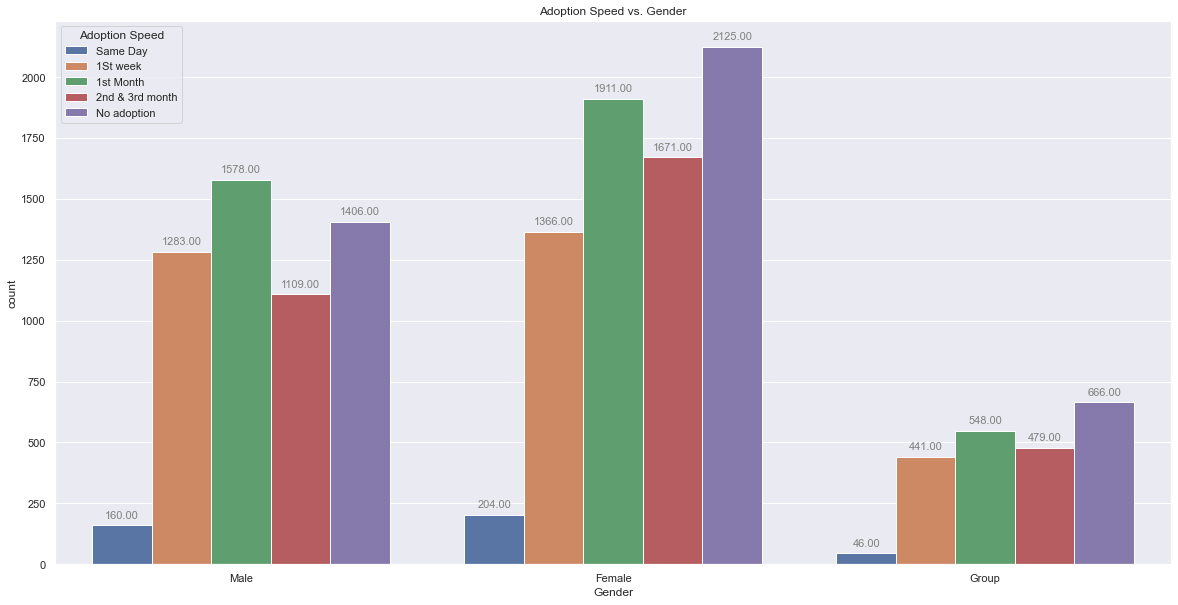

In [21]:
plt.figure(figsize=(20, 10));

ax=sns.countplot(data=train_df, x="Gender", hue="AdoptionSpeed")
ax.set_xticklabels(["Male","Female", "Group"])
ax.set_title('Adoption Speed vs. Gender')
plt.legend(title='Adoption Speed', loc='upper left', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption'])
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height() , (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
    

We can see that male are adopted more than the female gender or group.

For clearer visual, let's look at their percentage difference.

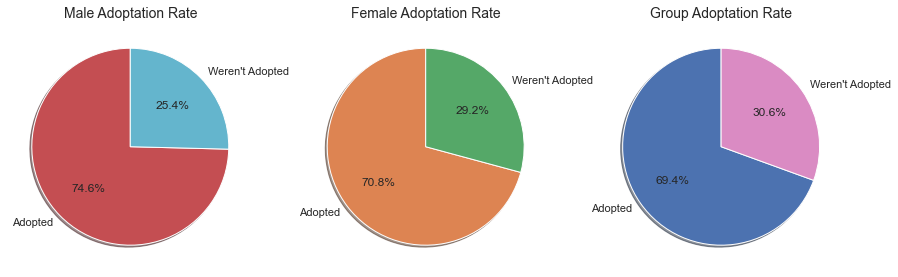

In [22]:
adopted_df=train_df.copy()
adopted_df['AdoptionSpeed'].replace(
    to_replace=[ 0, 1, 2 ,3 ],
    value='Yes',
    inplace=True
)
adopted_df['AdoptionSpeed'].replace(
    to_replace=[ 4 ],
    value='No',
    inplace=True
)
fig1, ax1 = plt.subplots(1,3,figsize=(15,5))
explode = (0, 0.1)
labels = "Adopted" ,"Weren't Adopted"
ax1[0].set_title("Male Adoptation Rate",fontsize=14)
ax1[1].set_title("Female Adoptation Rate",fontsize=14)
ax1[2].set_title("Group Adoptation Rate",fontsize=14)


ax1[0].pie([adopted_df[(adopted_df['Gender']==1) & (adopted_df['AdoptionSpeed']=='Yes')].count()[0],adopted_df[(adopted_df['Gender']==1) & (adopted_df['AdoptionSpeed']=='No')].count()[0]], autopct='%1.1f%%',
        shadow=True, startangle=90,colors=['C3','C9'],labels=labels)

ax1[1].pie([adopted_df[(adopted_df['Gender']==2) & (adopted_df['AdoptionSpeed']=='Yes')].count()[0],adopted_df[(adopted_df['Gender']==2) & (adopted_df['AdoptionSpeed']=='No')].count()[0]], autopct='%1.1f%%',
        shadow=True, startangle=90,colors=['C1','C2'],labels=labels)

ax1[2].pie([adopted_df[(adopted_df['Gender']==3) & (adopted_df['AdoptionSpeed']=='Yes')].count()[0],adopted_df[(adopted_df['Gender']==3) & (adopted_df['AdoptionSpeed']=='No')].count()[0]], autopct='%1.1f%%',
        shadow=True, startangle=90,colors=['C10','C6'],labels=labels)
plt.show()

We can also explore the color df to see how the pet colors affect adoption speed.

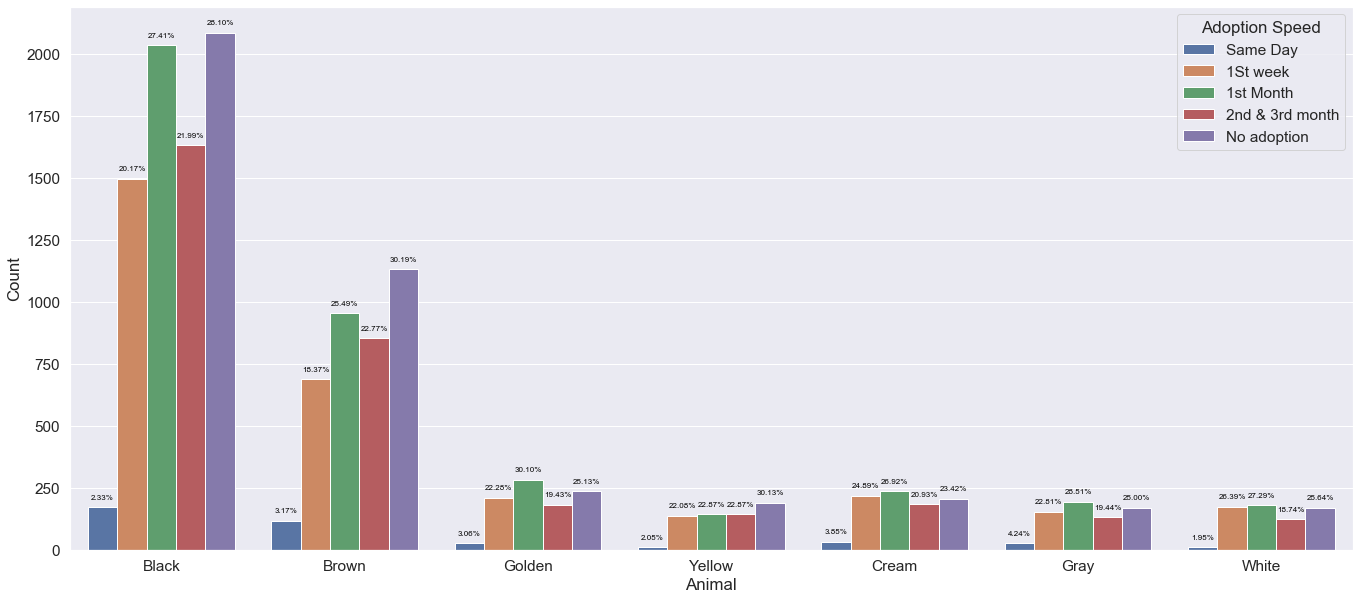

In [23]:
plt.figure(figsize=(23, 10));
sns.set(font_scale=1.4)
ax = sns.countplot(x="Color1",hue='AdoptionSpeed', data=train_df)
ax.set(xlabel = 'Animal', ylabel = 'Count')
ax.set_xticklabels(["Black","Brown","Golden","Yellow","Cream","Gray","White"])
color_percentage=[]

for i in range(1,8):
    color_percentage.append((train_df['Color1']==i).value_counts()[1])


for i,p in enumerate(ax.patches):
    ax.annotate("%.2f%%" % (p.get_height() *100  / color_percentage[i%7]) , (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=8, color='black', rotation=0, xytext=(0, 10),
         textcoords='offset points')  

plt.legend(title='Adoption Speed', loc='upper right', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption']);


It looks like colors matter and affect the adoption speed of these pets. We will check if it is same for both cats and dogs by creating different plots for both.

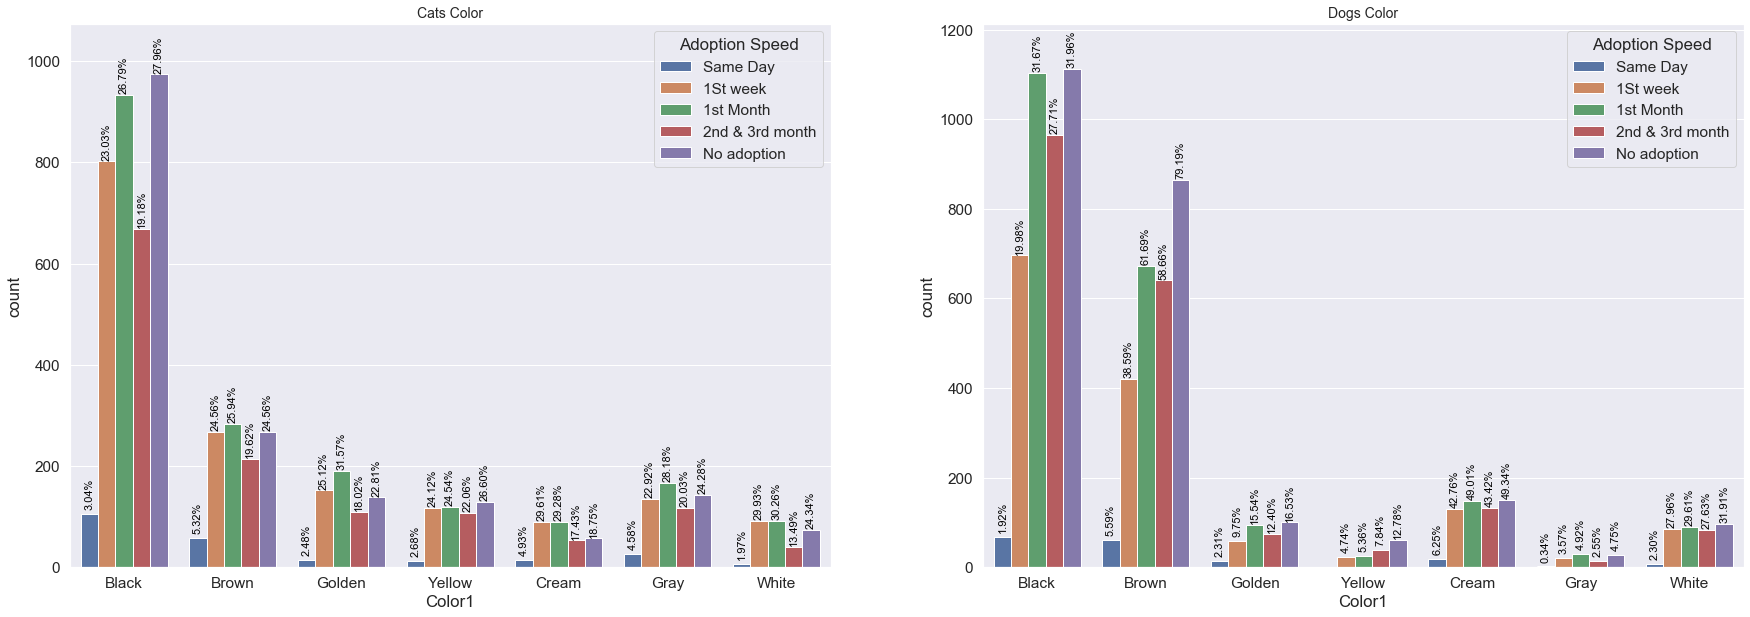

In [24]:
fig, ax = plt.subplots(1,2,figsize=(30,10))
ax[0].set_title("Cats Color",fontsize=14)
ax[1].set_title("Dogs Color",fontsize=14)

train_cats_df=train_df.copy()

train_cats_df.drop(train_cats_df[train_cats_df['Type'] ==1].index, inplace=True)

ax[0]=sns.countplot(data=train_cats_df, x="Color1",hue='AdoptionSpeed',ax=ax[0])
color_percentage=[]

for i in range(1,8):

    color_percentage.append((train_cats_df['Color1']==i).value_counts()[1])

max=0
for i,p in enumerate(ax[0].patches):
    
    ax[0].annotate("%.2f%%" % (p.get_height() *100  / color_percentage[i%7]) , (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=90, xytext=(0, 20),
         textcoords='offset points') 
    if p.get_height()>max:
        max=p.get_height()

ax[0].set_xticklabels(["Black","Brown","Golden","Yellow","Cream","Gray","White"])
ax[0].set_ylim(0,max+100)


###########Dogs
    
train_dogs_df=train_df.copy()
train_dogs_df.drop(train_dogs_df[train_dogs_df['Type'] ==2].index, inplace=True)
    
ax[1]=sns.countplot(data=train_dogs_df, x="Color1",hue='AdoptionSpeed',ax=ax[1])
colorP=[]

for i in range(1,8):
    color_percentage.append((train_dogs_df['Color1']==i).value_counts()[1])

max=0
for i,p in enumerate(ax[1].patches):
    
    ax[1].annotate("%.2f%%" % (p.get_height() *100  / color_percentage[i%7]) , (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=90, xytext=(0, 20),
         textcoords='offset points')
    if p.get_height()>max:
        max=p.get_height()
ax[1].set_xticklabels(["Black","Brown","Golden","Yellow","Cream","Gray","White"])
ax[1].set_ylim(0,max+100)


ax[0].legend(title='Adoption Speed', loc='upper right', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption'])
ax[1].legend(title='Adoption Speed', loc='upper right', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption']);

It looks like color affects both breeds alike, hence, people are more likely to adopt a black or brown pet to a colored one.

We will check how body fur affects adoption rate.

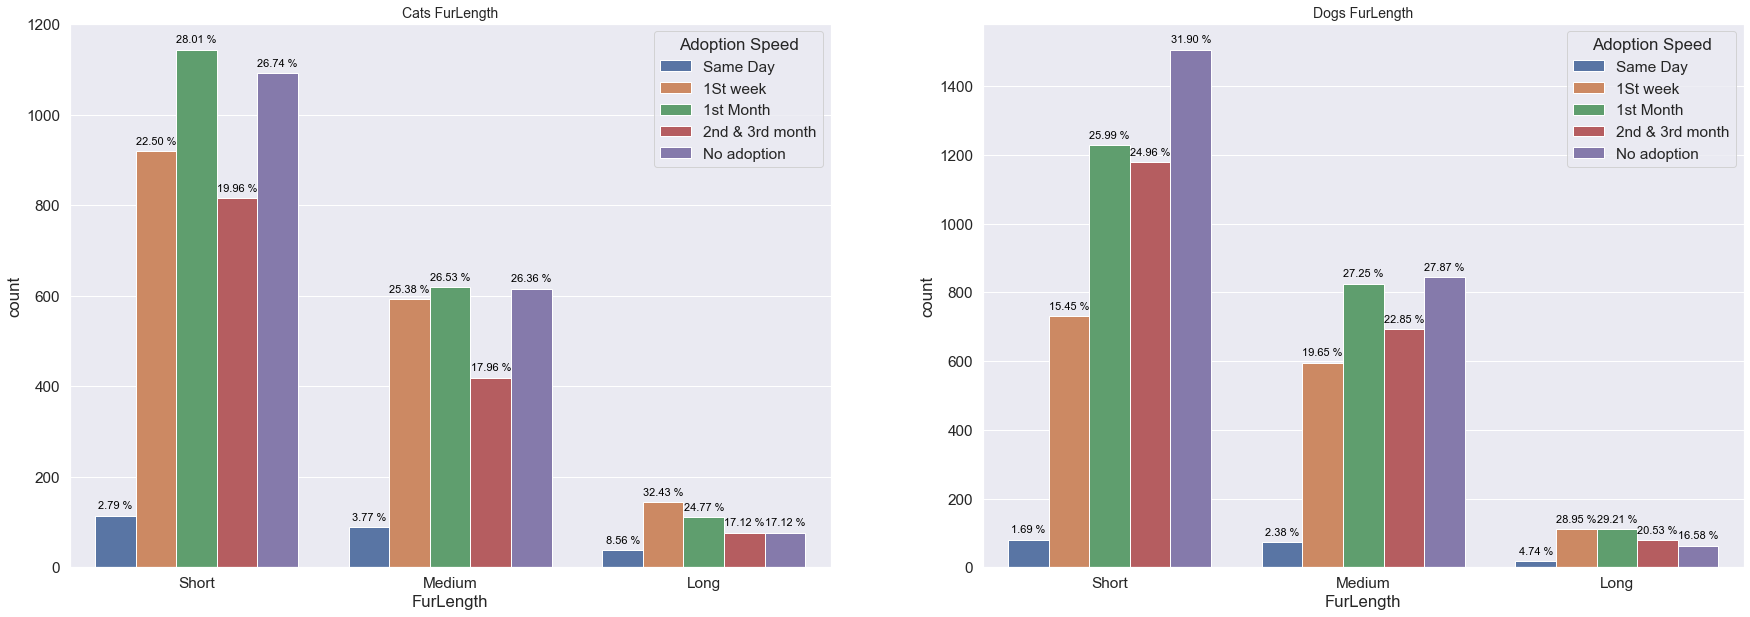

In [25]:
fig, ax = plt.subplots(1,2,figsize=(30,10))
ax[0].set_title("Cats FurLength",fontsize=14)
ax[1].set_title("Dogs FurLength",fontsize=14)

train_cats_df=train_df.copy()

train_cats_df.drop(train_cats_df[train_cats_df['Type'] ==1].index, inplace=True)

ax[0]=sns.countplot(data=train_cats_df, x="FurLength",hue='AdoptionSpeed',ax=ax[0])
perc_fur_length=[]

for i in range(1,4):

    perc_fur_length.append((train_cats_df['FurLength']==i).value_counts()[1])

for i,p in enumerate(ax[0].patches):
    
    ax[0].annotate("%.2f %%" % (p.get_height() *100  / perc_fur_length[i%3]) , (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 10),
         textcoords='offset points')  

###########Dogs
    
train_dogs_df=train_df.copy()
train_dogs_df.drop(train_dogs_df[train_dogs_df['Type'] ==2].index, inplace=True)
    
ax[1]=sns.countplot(data=train_dogs_df, x="FurLength",hue='AdoptionSpeed',ax=ax[1])
perc_fur_length=[]

for i in range(1,4):
    perc_fur_length.append((train_dogs_df['FurLength']==i).value_counts()[1])

for i,p in enumerate(ax[1].patches):
    
    ax[1].annotate("%.2f %%" % (p.get_height() *100  / perc_fur_length[i%3]) , (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 10),
         textcoords='offset points')  


ax[0].legend(title='Adoption Speed', loc='upper right', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption'])
ax[1].legend(title='Adoption Speed', loc='upper right', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption'])
ax[0].set_xticklabels(["Short","Medium", "Long"])
ax[1].set_xticklabels(["Short","Medium", "Long"]);

We can see a difference in adoption rate per dogs and per cats, looks like the fur length on dogs is more important than on cats.

Does a pet vaccination status affect the adoption speed?

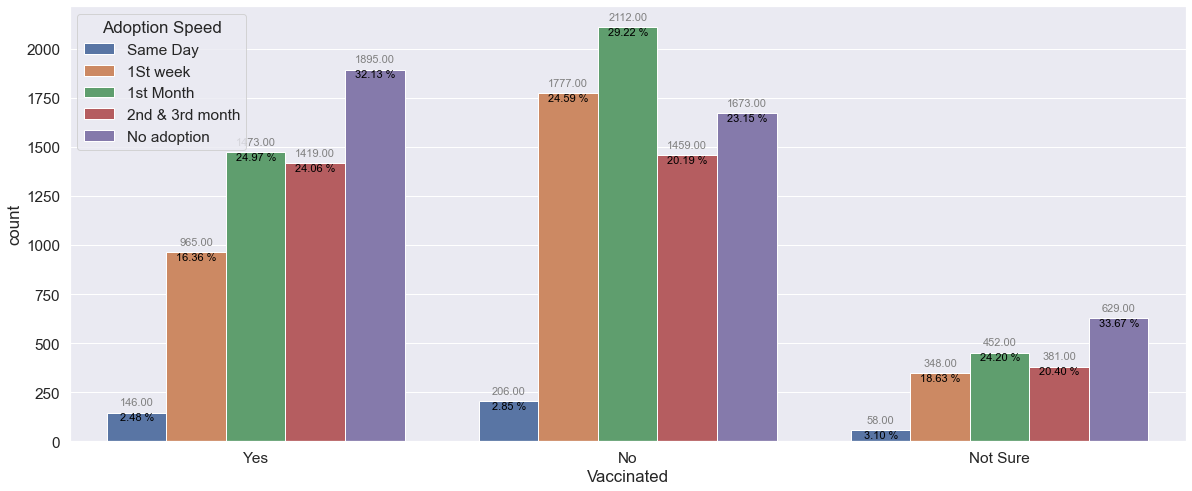

In [26]:
plt.figure(figsize=(20, 8))

ax=sns.countplot(data=train_df, x="Vaccinated", hue="AdoptionSpeed")
perc_vaccinated=[]

for i in range(1,4):
    perc_vaccinated.append((train_df['Vaccinated']==i).value_counts()[1])


plt.legend(title='Adoption Speed', loc='upper left', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption'])
for i,p in enumerate(ax.patches):
    ax.annotate("%.2f" % p.get_height() , (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
    ax.annotate("%.2f %%" % (p.get_height() *100  / perc_vaccinated[i%3]) , (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, -5),
         textcoords='offset points')  
ax.set_xticklabels(["Yes","No", "Not Sure"]); 

Looks like pets who are no vaccinated gets adopted faster, this is surprising as one would expect that the vaccinated pets are adopted faster, except these pets are young and yet to be vaccinated.

We can confirm this with our data.

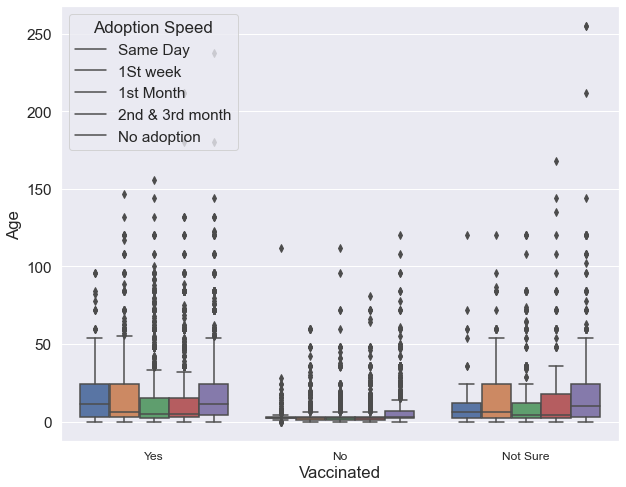

In [27]:
plt.figure(figsize=(10, 8))

ax=sns.boxplot(data=train_df, x="Vaccinated",y='Age',hue='AdoptionSpeed')
ax.set_xticklabels(['Yes','No','Not Sure'], fontsize=12)
ax.legend(title='Adoption Speed', loc='upper left', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption']);

Just like we assumed, most of the pets that are yet to be vaccinated are young.

We can also check if having a video of the pet affects the adoption speed.

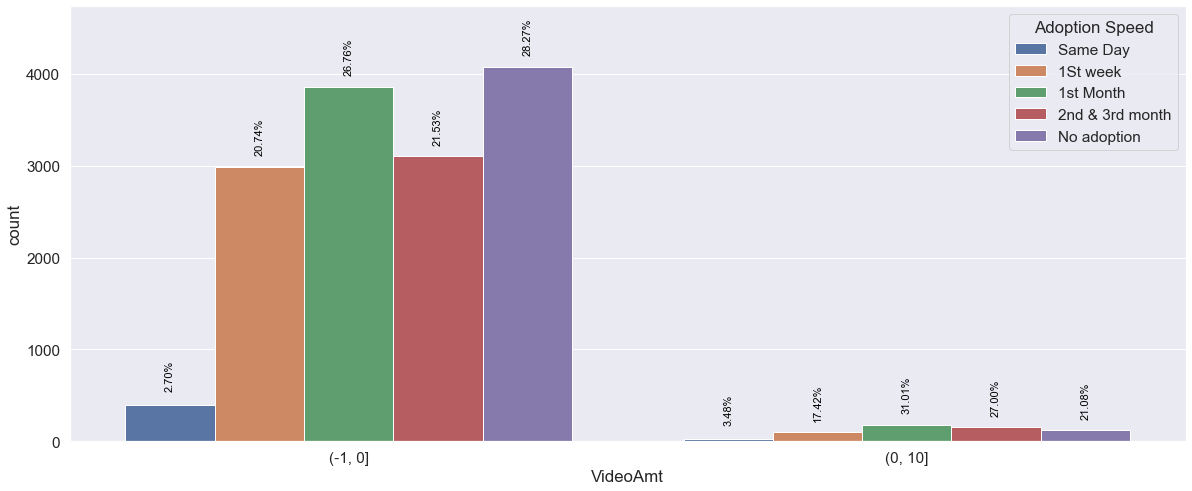

In [28]:
video_amt_df=train_df.copy()

video_amt_df['VideoAmt'] = pd.cut(video_amt_df['VideoAmt'], bins=[-1,0,10])
video_amt_df['VideoAmt'].value_counts()

plt.figure(figsize=(20, 8));


ax=sns.countplot(data=video_amt_df, x="VideoAmt",hue='AdoptionSpeed')
video_perc=[]
video_perc.append((video_amt_df['VideoAmt']==pd.Interval(-1, 0, closed='right')).value_counts()[1])
video_perc.append((video_amt_df['VideoAmt']==pd.Interval(0, 10, closed='right')).value_counts()[1])


plt.legend(title='Adoption Speed', loc='upper right', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption'])
max=0
for i,p in enumerate(ax.patches):
    
    ax.annotate("%.2f%%" % (p.get_height() *100  / video_perc[i%2]) , (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=90, xytext=(0, 30),
         textcoords='offset points')
    if p.get_height()>max:
        max=p.get_height()
ax.set_ylim(0,max+ 660);

We can see that having a video of the pet of any length leads to adoption of the pet. Hence, a short video of the pet could increase adoption as well.

Now let's look more into the description and see how it affects adoption

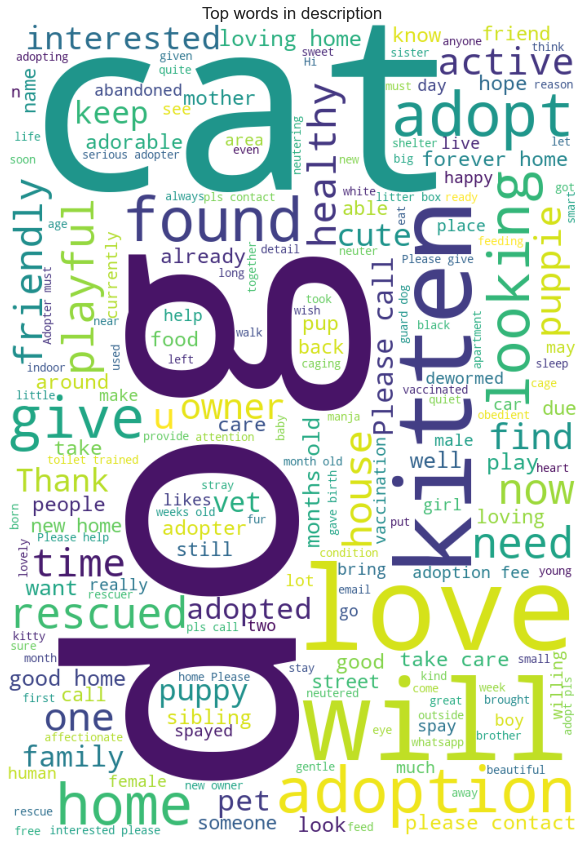

In [29]:
train_df['Description']=train_df['Description'].fillna('').values
fig, ax = plt.subplots(figsize = (15, 15))
Description = ' '.join(train_df['Description'])
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=700, height=1000).generate(Description)
plt.axis("off");
plt.imshow(wordcloud)
plt.title('Top words in description');

We can see the popular words. We will also check if having a longer summary of your pets helps adoption.

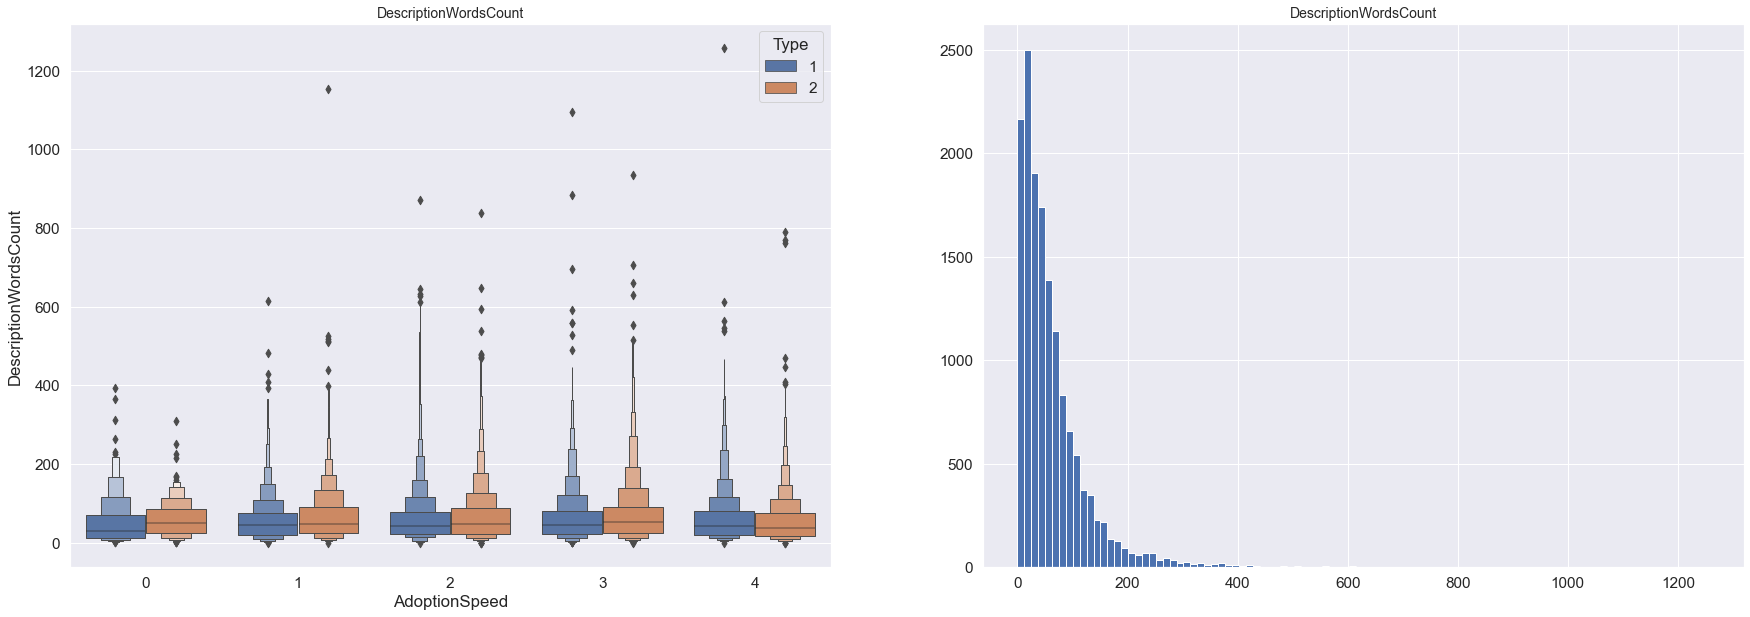

In [30]:
train_df['DescriptionWordsCount'] = train_df['Description'].apply(lambda x: len(x.split()))
fig, ax = plt.subplots(1,2,figsize=(30,10))
ax[0].set_title("DescriptionWordsCount",fontsize=14)
ax[1].set_title("DescriptionWordsCount",fontsize=14)
ax[0]=sns.boxenplot(x="AdoptionSpeed", y="DescriptionWordsCount", hue="Type", data=train_df,ax=ax[0]);
ax[1]=plt.hist(train_df.DescriptionWordsCount,bins=100)

Although, the data is skewed because ordinarily most people will rather give a shorter summary than a longer summary.

Let's look at the images data and see if we can get some insights from there.

Most common Breeds of Small 2s:


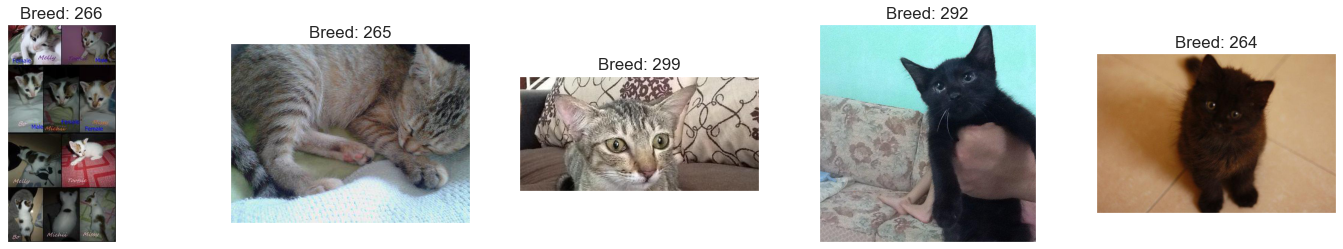

Most common Breeds of Medium 2s:


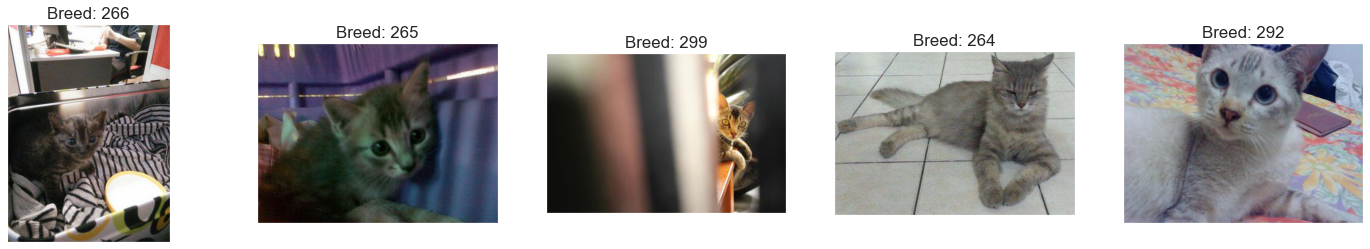

Most common Breeds of Large 2s:


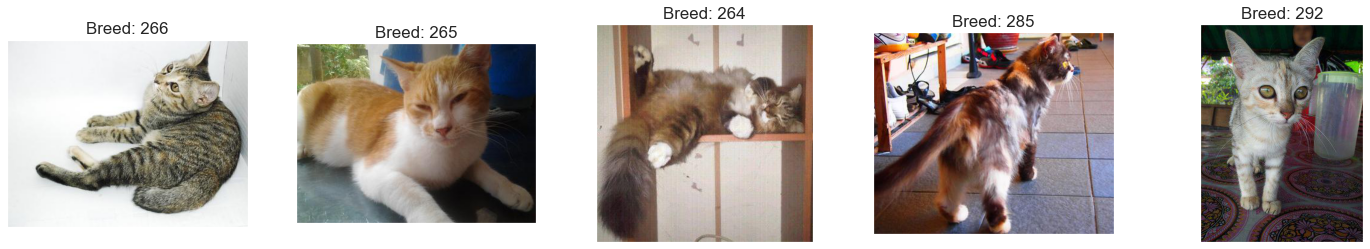

Most common Breeds of Extra Large 2s:


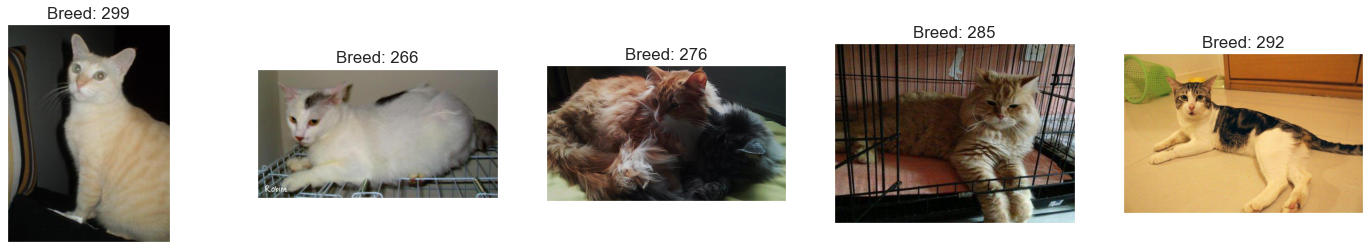

Most common Breeds of Small 1s:


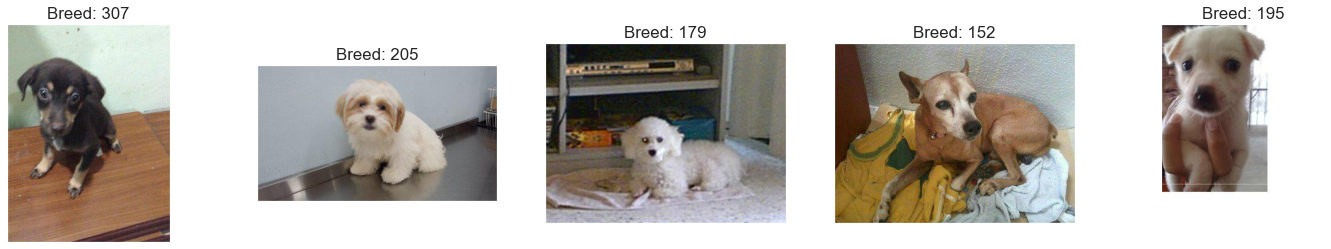

Most common Breeds of Medium 1s:


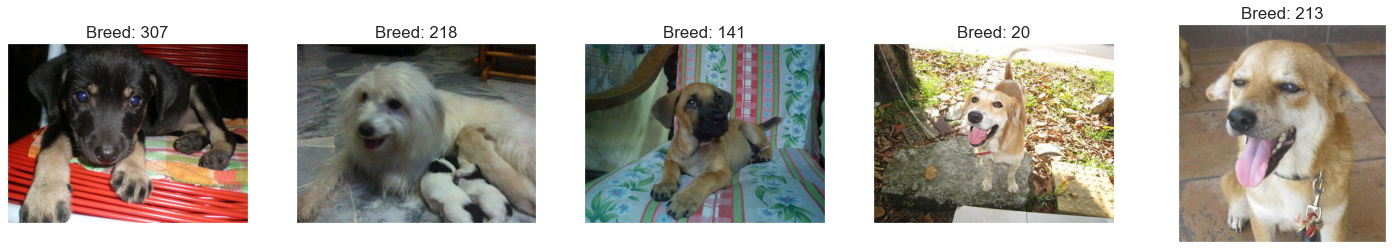

Most common Breeds of Large 1s:


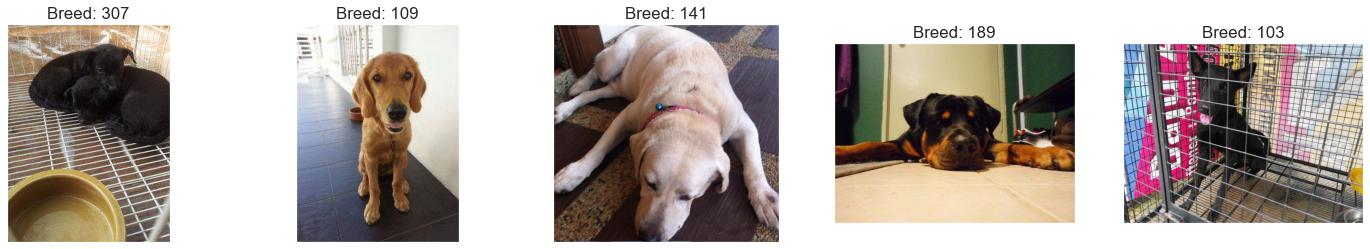

Most common Breeds of Extra Large 1s:


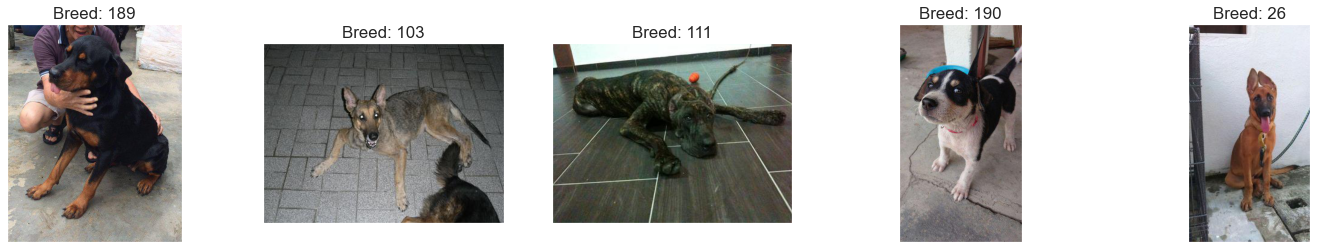

In [31]:
images = [i.split('-')[0] for i in os.listdir('train_images/')]
size_dict = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large'}
for t in train_df['Type'].unique():
    for m in train_df['MaturitySize'].unique():
        df = train_df.loc[(train_df['Type'] == t) & (train_df['MaturitySize'] == m)]
        top_breeds = list(df['Breed1'].value_counts().index)[:5]
        m = size_dict[m]
        print(f"Most common Breeds of {m} {t}s:")
        
        fig = plt.figure(figsize=(25, 4))
        
        for i, breed in enumerate(top_breeds):
            # excluding pets without pictures
            b_df = df.loc[(df['Breed1'] == breed) & (df['PetID'].isin(images)), 'PetID']
            if len(b_df) > 1:
                pet_id = b_df.values[1]
            else:
                pet_id = b_df.values[0]
            ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])

            im = Image.open("train_images/" + pet_id + '-1.jpg')
            plt.imshow(im)
            ax.set_title(f'Breed: {breed}')
        plt.show();

We can see some of the see the most common breeds according to their sizes.We can also see that the So-called Extra-Large sizes are not so extra-large looking in the pictures. This could be why people prefer to see pictures before adopting a pet.


Let's look at the quantity of pets available

In [32]:
train_df.loc[train_df['Quantity'] > 11][['Name', 'Description', 'Quantity', 'AdoptionSpeed']].head(10)

Name  \
263                    20 Little Puppies   
320             18 Cats For NEED HOMES!!   
396    Giant, Cookie & Snoopy. ! Thanks!   
427                         OMIEY'S HOME   
823                        Pancho & Tita   
1302                                NULL   
1305                              Bailey   
1404                                NULL   
1659  Cats From TTDI Now In Omiey's Home   
2558     ( 0 Puppies Left  )14+2 Puppies   

                                            Description  Quantity  \
263   These are 20 puppies, from 2 stray mums need g...        20   
320   YOU can CONTACT the couple at if you are inter...        18   
396   puppies for adoption. Rescued by some good sam...        12   
427   Hi, kepada sesiapa yang berminat untuk adopt k...        20   
823   Pancho and Tita are 2 adorable, playful kitten...        12   
1302  Sebare Bengal is a specialist catery breeding ...        14   
1305  Bailey is an obedient and loyal dog Her owner ...        20   
1404  I had uploaded the pups' group photos earlier....        17   
1659  Hi feline lovers, There are 40 cats desperatel...        20   
2558  They are 2 stray mother dogs gave birth 14 pup...        16   

      AdoptionSpeed  
263               4  
320               4  
396               2  
427               4  
823               2  
1302              4  
1305              4  
1404              2  
1659              2  
2558              2

In [33]:
train_df['Quantity'].value_counts().head(10)

1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
Name: Quantity, dtype: int64

Looks like sometimes the quantity and description don't match. For example, id 823, says Pancho & Tita are 2 adorable kittens but the quantity says 12.


Let's see if fee for a type of pet affects adoption speed.

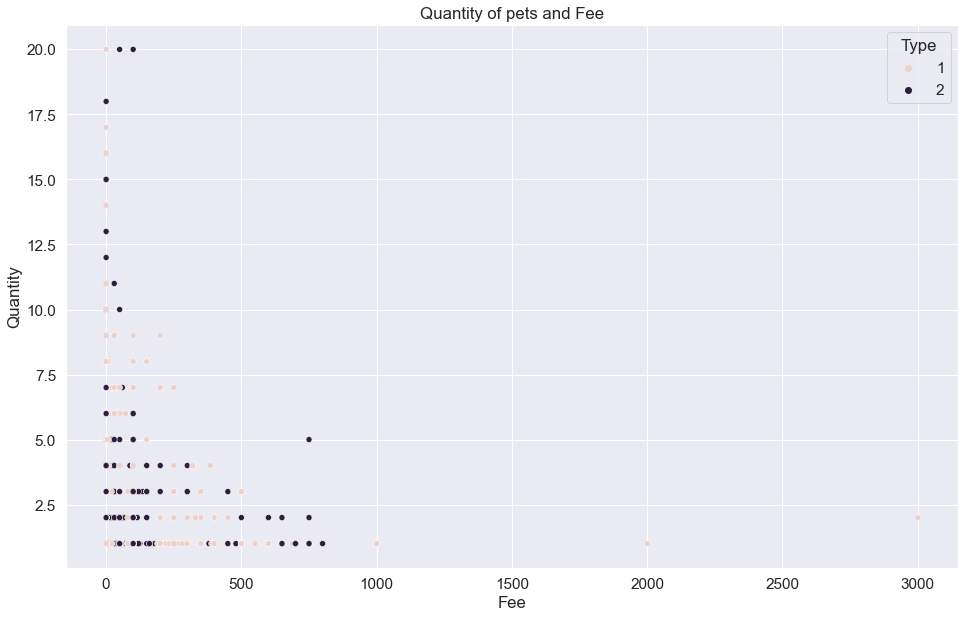

In [34]:
plt.figure(figsize=(16, 10));
sns.scatterplot(x="Fee", y="Quantity", hue="Type",data=train_df);
plt.title('Quantity of pets and Fee');

It looks like fees and quantity are inversely related, as with smaller quantities the fees are more. 


Let's take a look at the sentiment data and see what we can get from it

In [35]:
# load sentiment files
train_sentiment_files = sorted(glob.glob('train_sentiment/*.json'))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))
data=[]

for i in range (len(train_sentiment_files)):
    with open(train_sentiment_files[i]) as jsonFile:
        jsonObject = json.load(jsonFile)
        jsonFile.close()
    score=jsonObject['documentSentiment']['score']
    magnitude=jsonObject['documentSentiment']['magnitude']
    path=train_sentiment_files[i]
    firstpos=path.rfind("/")
    lastpos=path.rfind(".")
    PetID=path[firstpos+1:lastpos]
    data.append([PetID,score,magnitude,score*magnitude])
data = pd.DataFrame(data, columns=['PetID','Score', 'Magnitude','Sentiment'])

df_train=pd.merge(train_df, data, on='PetID',how='outer')
df_train=df_train.fillna(0)

num of train sentiment files: 14442


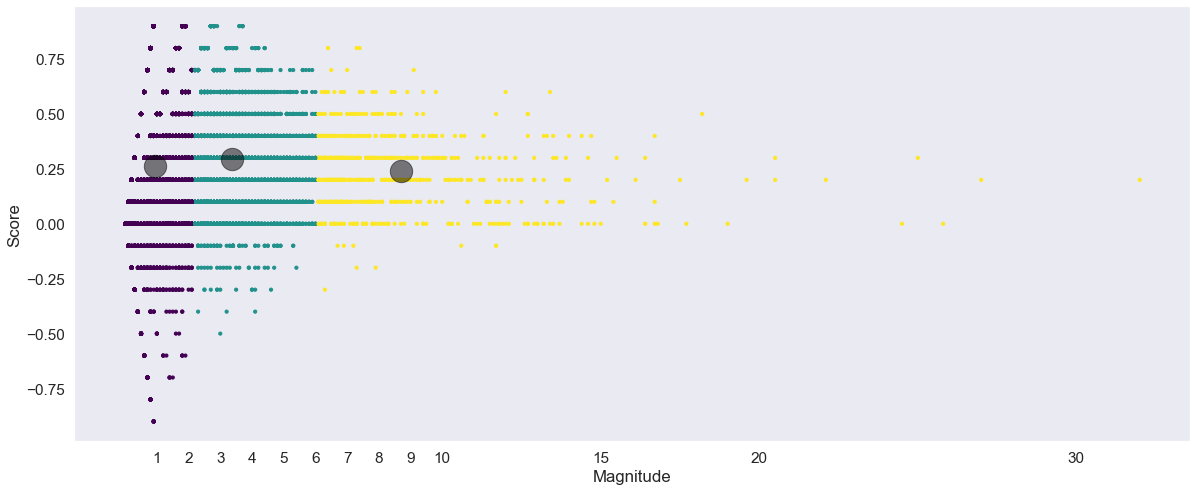

In [36]:
plt.figure(figsize=(20, 8));

cluster_df=df_train.copy()
cluster_df=cluster_df.drop(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 
       'DescriptionWordsCount'],axis=1)


kmeans = KMeans(n_clusters=3, random_state=0).fit(cluster_df[['Score','Magnitude']])
y_kmeans = kmeans.predict(cluster_df[['Score','Magnitude']])

plt.scatter( cluster_df['Magnitude'],cluster_df['Score'], c=y_kmeans, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.xticks([1,2,3,4,5,6,7,8,9,10,15,20,30])
plt.grid(which='both')
plt.xlabel('Magnitude')
plt.ylabel('Score')
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=500, alpha=0.5);

The score of a document's sentiment indicates the overall emotion of a document.

The magnitude of a document's sentiment indicates how much emotional content is present within the document, and this value is often proportional to the length of the document.

From the above, we can see that cluster of 3 seperates the data well, we could use this when working with our sentiments data.


Now that we have merged the sentiment data and the train data, we will also engineer some features that can help our model.

We will create a column that represents the magnitude and score of the sentiment data. 

In [37]:
data=[]

for i in range (len(train_sentiment_files)):
    with open(train_sentiment_files[i]) as jsonFile:
        jsonObject = json.load(jsonFile)
        jsonFile.close()
    score=jsonObject['documentSentiment']['score']
    magnitude=jsonObject['documentSentiment']['magnitude']
    path=train_sentiment_files[i]
    firstpos=path.rfind("/")
    lastpos=path.rfind(".")
    PetID=path[firstpos+1:lastpos]
    if score >=0.1:
        if magnitude < 2:
            data.append([PetID,'Weak Postive'])
        elif magnitude < 6 and magnitude>=2:
            data.append([PetID,'Medium Postive'])
        elif magnitude >=6:
            data.append([PetID,'Strong Postive'])
            
    elif score <=-0.1 :
        if magnitude < 2:
            data.append([PetID,'Weak Negative'])
        elif magnitude < 6 and magnitude>=2:
            data.append([PetID,'Medium Negative'])
        elif magnitude >=6:
            data.append([PetID,'Strong Negative'])
            
    else:
        data.append([PetID,'Netural'])

data = pd.DataFrame(data, columns=['PetID','sentiment_TEXT'])

df_train=pd.merge(df_train, data, on='PetID',how='outer')
df_train=df_train.drop(['Score','Magnitude','Sentiment'],axis=1)

In [38]:
df_train.head(2)

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   

   MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   

   Quantity  Fee  State                         RescuerID  VideoAmt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   

                                         Description      PetID  PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   

   AdoptionSpeed  DescriptionWordsCount  sentiment_TEXT  
0              2                     69  Medium Postive  
1              0                     23   Weak Negative

Weak Postive       6211
Medium Postive     4630
Netural            2328
Weak Negative       587
Strong Postive      557
Medium Negative     120
Strong Negative       9
Name: sentiment_TEXT, dtype: int64


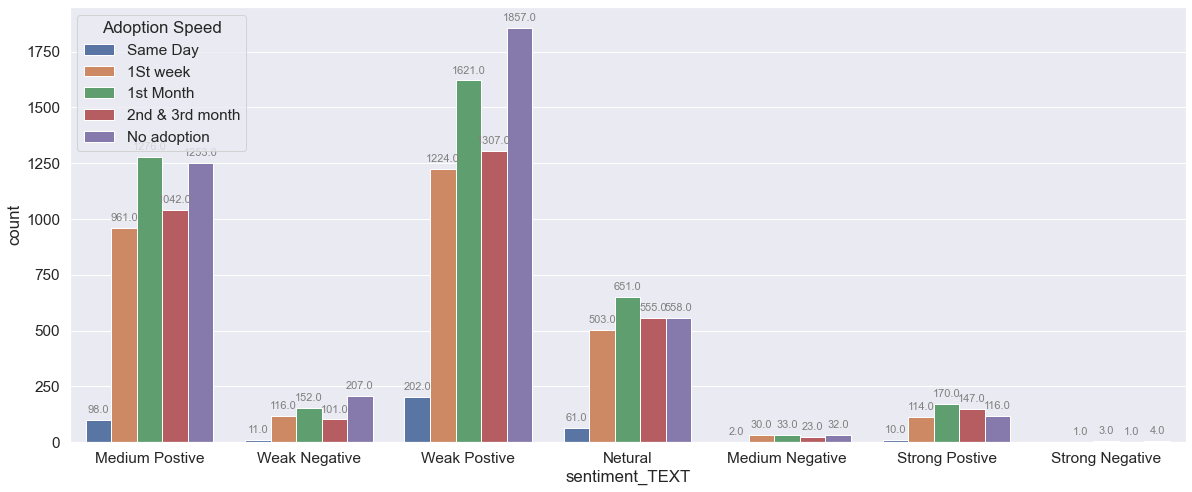

In [39]:
plt.figure(figsize=(20, 8))

ax=sns.countplot(data=df_train, x="sentiment_TEXT", hue="AdoptionSpeed")
sentimentP=[]
print(df_train['sentiment_TEXT'].value_counts())



plt.legend(title='Adoption Speed', loc='upper left', labels=['Same Day', '1St week','1st Month','2nd & 3rd month','No adoption'])
for i,p in enumerate(ax.patches):
    ax.annotate(  p.get_height() , (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
  

**Summary**
- There are lots of interetsing findings from this data, and there can even be more that can be gotten with the rich data sets
- The dataset can be split into cats and dogs and modelled seperately
- At the same time the modeling could be Natural Language processing where the descriptions and sentments are modeled or it the images could be modeled with neural networks.
- For this notebook, I will try to keep it simple.

## Feature Engineering

There are lots of features and dataset to work with. I will try to use as many as possible to create features and build a simple model.

We would:
- remove Outliers and Normalize Numerical columns
- work with one hot encoding for categorical data

In [40]:
train_dropped_df=df_train.copy()
columns_to_drop = ['Breed2', 'State','RescuerID','Description','Color2','Color3','PetID']
train_dropped_df.drop(columns_to_drop, axis=1, inplace=True)


test_dropped_df=test_df.copy()
test_dropped_df['Description']=test_dropped_df['Description'].fillna('').values
test_dropped_df['DescriptionWordsCount'] = test_dropped_df['Description'].apply(lambda x: len(x.split()))

test_dropped_df.drop(columns_to_drop, axis=1, inplace=True)

In [41]:
train_cleaned_df=train_dropped_df.copy()
test_cleaned_df=test_dropped_df.copy()

In [42]:
#replace no names with NULL
train_cleaned_df['Name'] =train_cleaned_df['Name'].fillna('NULL')
train_cleaned_df['Name'].replace({"No Name": "NULL", "No Name Yet": "NULL", "Unknown": "NULL"},inplace=True)
train_cleaned_df.loc[train_cleaned_df['Name'] !="NULL", 'Name'] = 'HasName'
print(train_cleaned_df['Name'].value_counts())

test_cleaned_df['Name'] = test_cleaned_df['Name'].fillna('NULL')
test_cleaned_df['Name'].replace({"No Name": "NULL", "No Name Yet": "NULL", "Unknown": "NULL"},inplace=True)
test_cleaned_df.loc[test_cleaned_df['Name'] !="NULL", 'Name'] = 'HasName'

HasName    13645
NULL        1348
Name: Name, dtype: int64


Just as we did in the EDA, we will bin the Breed1 to different categories.

In [43]:
train_cleaned_df.loc[(train_cleaned_df['Breed1']!=266) & (train_cleaned_df['Breed1']!=265) & (train_cleaned_df['Breed1']!=264) & (train_cleaned_df['Breed1']!=307) & (train_cleaned_df['Type']== 2),'Breed1'] ="Pure Cats"
train_cleaned_df.loc[(train_cleaned_df['Breed1']!=266) & (train_cleaned_df['Breed1']!=265) & (train_cleaned_df['Breed1']!=264) & (train_cleaned_df['Breed1']!=307) & (train_cleaned_df['Type']== 1),'Breed1'] ="Pure Dogs"
train_cleaned_df.loc[(train_cleaned_df['Breed1']==307),'Breed1']='Mixed Dog'
train_cleaned_df.loc[(train_cleaned_df['Breed1']==266),'Breed1']='Domestic short Hair Cat'
train_cleaned_df.loc[(train_cleaned_df['Breed1']==265),'Breed1']='Domestic Medium Hair Cat'
train_cleaned_df.loc[(train_cleaned_df['Breed1']==264),'Breed1']='Domestic Long Hair Cat'

print(train_cleaned_df['Breed1'].value_counts())

test_cleaned_df.loc[(test_cleaned_df['Breed1']!=266) & (test_cleaned_df['Breed1']!=265) & (test_cleaned_df['Breed1']!=264) & (test_cleaned_df['Breed1']!=307) & (test_cleaned_df['Type']== 2),'Breed1'] ="Pure Cats"
test_cleaned_df.loc[(test_cleaned_df['Breed1']!=266) & (test_cleaned_df['Breed1']!=265) & (test_cleaned_df['Breed1']!=264) & (test_cleaned_df['Breed1']!=307) & (test_cleaned_df['Type']== 1),'Breed1'] ="Pure Dogs"
test_cleaned_df.loc[(test_cleaned_df['Breed1']==307),'Breed1']='Mixed Dog'
test_cleaned_df.loc[(test_cleaned_df['Breed1']==266),'Breed1']='Domestic short Hair Cat'
test_cleaned_df.loc[(test_cleaned_df['Breed1']==265),'Breed1']='Domestic Medium Hair Cat'
test_cleaned_df.loc[(test_cleaned_df['Breed1']==264),'Breed1']='Domestic Long Hair Cat'

Mixed Dog                   5927
Domestic short Hair Cat     3634
Pure Dogs                   2209
Pure Cats                   1669
Domestic Medium Hair Cat    1258
Domestic Long Hair Cat       296
Name: Breed1, dtype: int64


We will also change the gender group to number category

In [44]:
train_cleaned_df.loc[(train_cleaned_df['Gender']==1),'Gender']='Male'
train_cleaned_df.loc[(train_cleaned_df['Gender']==2),'Gender']='Female'
train_cleaned_df.loc[(train_cleaned_df['Gender']==3),'Gender']='Mixed'

test_cleaned_df.loc[(test_cleaned_df['Gender']==1),'Gender']='Male'
test_cleaned_df.loc[(test_cleaned_df['Gender']==2),'Gender']='Female'
test_cleaned_df.loc[(test_cleaned_df['Gender']==3),'Gender']='Mixed'

Change Color1 Labels to:
- 1-Black 
- 2-Brown 
- 3-Golden 
- 4-Yellow 
- 5-Cream 
- 6-Gray 
- 7-White

In [45]:
colors=["Nan","Black","Brown","Golden","Yellow","Cream","Gray","White"]

for i in range(1,8):
    train_cleaned_df.loc[(train_cleaned_df['Color1']==i),'Color1']=colors[i]
    
print(train_cleaned_df['Color1'].value_counts())

colors=["Nan","Black","Brown","Golden","Yellow","Cream","Gray","White"]

for i in range(1,8):
    test_cleaned_df.loc[(test_cleaned_df['Color1']==i),'Color1']=colors[i]

Black     7427
Brown     3750
Golden     947
Cream      884
Gray       684
White      667
Yellow     634
Name: Color1, dtype: int64


In [46]:
# binning fee column to free or paid

train_cleaned_df.loc[train_cleaned_df['Fee']>=1, 'Fee']='Not Free'
train_cleaned_df.loc[train_cleaned_df['Fee']==0, 'Fee']='Free'

test_cleaned_df.loc[test_cleaned_df['Fee']>=1, 'Fee']='Not Free'
test_cleaned_df.loc[test_cleaned_df['Fee']==0, 'Fee']='Free'

In [47]:
train_cleaned_df.loc[train_cleaned_df['VideoAmt']>=1, 'VideoAmt']='YesVideo'
train_cleaned_df.loc[train_cleaned_df['VideoAmt']==0, 'VideoAmt']='NoVideo'

test_cleaned_df.loc[test_cleaned_df['VideoAmt']>=1, 'VideoAmt']='YesVideo'
test_cleaned_df.loc[test_cleaned_df['VideoAmt']==0, 'VideoAmt']='NoVideo'

In [48]:
train_cleaned_df['Type'] = pd.Categorical(train_cleaned_df.Type)
train_cleaned_df['Gender'] = pd.Categorical(train_cleaned_df.Gender)
train_cleaned_df['Vaccinated'] = pd.Categorical(train_cleaned_df.Vaccinated)
train_cleaned_df['Dewormed'] = pd.Categorical(train_cleaned_df.Dewormed)
train_cleaned_df['Sterilized'] = pd.Categorical(train_cleaned_df.Sterilized)
train_cleaned_df['Health'] = pd.Categorical(train_cleaned_df.Health)
train_cleaned_df=pd.get_dummies(train_cleaned_df)

test_cleaned_df['Type'] = pd.Categorical(test_cleaned_df.Type)
test_cleaned_df['Gender'] = pd.Categorical(test_cleaned_df.Gender)
test_cleaned_df['Vaccinated'] = pd.Categorical(test_cleaned_df.Vaccinated)
test_cleaned_df['Dewormed'] = pd.Categorical(test_cleaned_df.Dewormed)
test_cleaned_df['Sterilized'] = pd.Categorical(test_cleaned_df.Sterilized)
test_cleaned_df['Health'] = pd.Categorical(test_cleaned_df.Health)
test_cleaned_df=pd.get_dummies(test_cleaned_df)

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64
count    14615.000000
mean         8.351488
std         12.037444
min          0.000000
25%          2.000000
50%          3.000000
75%          9.000000
max         64.000000
Name: Age, dtype: float64


<AxesSubplot:xlabel='Age', ylabel='Count'>

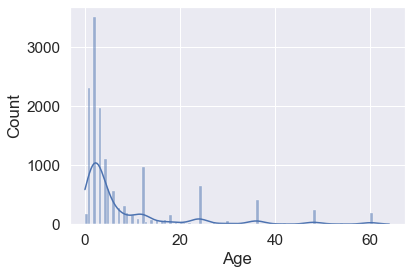

In [49]:
#age outliers
print(train_cleaned_df['Age'].describe())
train_cleaned_df=train_cleaned_df[(np.abs(stats.zscore(train_cleaned_df['Age'])) < 3)]
print(train_cleaned_df['Age'].describe())
sns.histplot(data=train_cleaned_df, x='Age',kde=True)

count    14615.000000
mean         3.912077
std          3.500533
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: PhotoAmt, dtype: float64
count    14332.000000
mean         3.592241
std          2.603131
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         14.000000
Name: PhotoAmt, dtype: float64


<AxesSubplot:xlabel='PhotoAmt', ylabel='Count'>

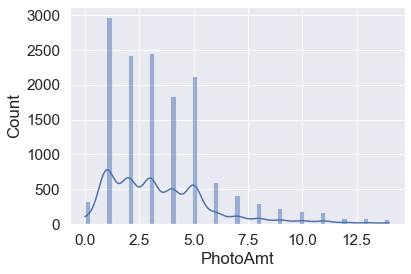

In [50]:
print(train_cleaned_df['PhotoAmt'].describe())
train_cleaned_df=train_cleaned_df[(np.abs(stats.zscore(train_cleaned_df['PhotoAmt'])) < 3)]
print(train_cleaned_df['PhotoAmt'].describe())

sns.histplot(data=train_cleaned_df, x='PhotoAmt',kde=True)

count    14332.000000
mean         1.570541
std          1.451413
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         20.000000
Name: Quantity, dtype: float64
count    13944.000000
mean         1.398523
std          0.913705
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: Quantity, dtype: float64


<AxesSubplot:xlabel='Quantity', ylabel='Count'>

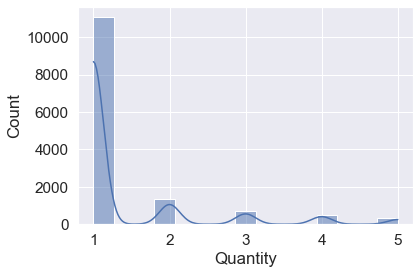

In [51]:
print(train_cleaned_df['Quantity'].describe())
train_cleaned_df=train_cleaned_df[(np.abs(stats.zscore(train_cleaned_df['Quantity'])) < 3)]
print(train_cleaned_df['Quantity'].describe())

sns.histplot(data=train_cleaned_df, x='Quantity',kde=True)

count    13944.000000
mean        61.205536
std         66.060187
min          0.000000
25%         21.000000
50%         43.000000
75%         79.000000
max       1257.000000
Name: DescriptionWordsCount, dtype: float64
count    13693.000000
mean        55.595268
std         48.363082
min          0.000000
25%         20.000000
50%         42.000000
75%         77.000000
max        259.000000
Name: DescriptionWordsCount, dtype: float64


<AxesSubplot:xlabel='DescriptionWordsCount', ylabel='Count'>

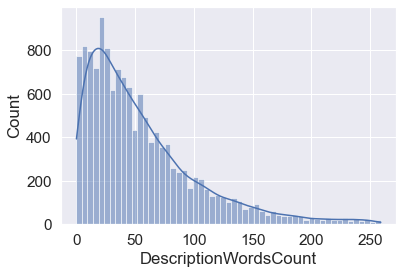

In [52]:
print(train_cleaned_df['DescriptionWordsCount'].describe())
train_cleaned_df=train_cleaned_df[(np.abs(stats.zscore(train_cleaned_df['DescriptionWordsCount'])) < 3)]
print(train_cleaned_df['DescriptionWordsCount'].describe())

sns.histplot(data=train_cleaned_df, x='DescriptionWordsCount',kde=True)

In [53]:
#Let's normalize our data
column_names_to_normalize = ['Age','MaturitySize','FurLength','Quantity','PhotoAmt','DescriptionWordsCount']
x = train_cleaned_df[column_names_to_normalize].values
scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = train_cleaned_df.index)
train_cleaned_df[column_names_to_normalize] = df_temp

column_names_to_normalize = ['Age','MaturitySize','FurLength','Quantity','PhotoAmt','DescriptionWordsCount']
x = test_cleaned_df[column_names_to_normalize].values
scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = test_cleaned_df.index)
test_cleaned_df[column_names_to_normalize] = df_temp

In [54]:
train= train_cleaned_df.copy()
train = train.drop(['AdoptionSpeed'],axis=1)
y = train_cleaned_df['AdoptionSpeed']


x_test=test_cleaned_df.copy()

In [55]:
#Spilting to dogs and cats df
#making a Dog DS
dogs_train_data=train_cleaned_df[(train_cleaned_df['Type_1']==1)]
dogs_train_data=dogs_train_data.drop(['Type_2'],axis=1)
dogs_train_data=dogs_train_data.drop(['Type_1'],axis=1)
dogs_target=dogs_train_data.copy()
dogs_target=dogs_target['AdoptionSpeed']
dogs_train_data=dogs_train_data.drop(['AdoptionSpeed'],axis=1)

#Making a Cat DS
cats_train_data=train_cleaned_df[(train_cleaned_df['Type_1']==0)]
cats_train_data=cats_train_data.drop(['Type_2'],axis=1)
cats_train_data=cats_train_data.drop(['Type_1'],axis=1)
cats_target=cats_train_data.copy()
cats_target=cats_target['AdoptionSpeed']
cats_train_data=cats_train_data.drop(['AdoptionSpeed'],axis=1)

In [56]:
def quadratic_kappa(actuals, preds, N=5) -> float:
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

### Baseline

In [57]:
#combined model
data_dmatrix = xgb.DMatrix(data=train,label=y)
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state=42,
                                                    stratify=y)

In [58]:
# Cats and Dogs Models
dogs_data_dmatrix = xgb.DMatrix(data=dogs_train_data,label=dogs_target)
cats_data_dmatrix = xgb.DMatrix(data=cats_train_data,label=cats_target)

X_train_dogs, X_test_dogs, y_train_dogs, y_test_dogs = train_test_split(dogs_train_data, dogs_target,
                                                                        test_size=0.25, random_state=42)
X_train_cats, X_test_cats, y_train_cats, y_test_cats = train_test_split(cats_train_data, cats_target, 
                                                                        test_size=0.25, random_state=42)

In [59]:
model = XGBClassifier( colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 15, alpha = 20, n_estimators = 20,use_label_encoder=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(quadratic_kappa(y_test, predictions))

[16:09:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 39.37%
0.30565605051557243


This is not a bad Kappa score for baseline considering the fact that the kappa score that won the competition is 45%.
Let's model the separated data

In [60]:
dogs_model = XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 15, alpha = 20, n_estimators = 20, use_label_encoder=False)
dogs_model.fit(X_train_dogs, y_train_dogs)
y_pred_dogs = dogs_model.predict(X_test_dogs)
predictions_dogs = [round(value) for value in y_pred_dogs]
accuracy_dogs = accuracy_score(y_test_dogs, predictions_dogs)
print('Dogs Model Details:')
print("Accuracy: %.2f%%" % (accuracy_dogs * 100.0))
print(f'Quadratic_kappa {quadratic_kappa(y_test_dogs, predictions_dogs)}')


cats_model = XGBClassifier( colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 15, alpha = 20, n_estimators = 20,use_label_encoder=False)
cats_model.fit(X_train_cats, y_train_cats)
y_pred_cats = cats_model.predict(X_test_cats)

predictions_cats = [round(value) for value in y_pred_cats]
accuracy_cats = accuracy_score(y_test_cats, predictions_cats)
print('Cats Model Details:')
print("Accuracy: %.2f%%" % (accuracy_cats * 100.0))
print(f'Quadratic_kappa {quadratic_kappa(y_test_cats, predictions_cats)}')

[16:09:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Dogs Model Details:
Accuracy: 40.76%
Quadratic_kappa 0.32723985398872424
[16:09:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cats Model Details:
Accuracy: 36.49%
Quadratic_kappa 0.30005587441929804


In [61]:
print(tabulate([['CombinedModel', accuracy * 100.0,quadratic_kappa(y_test, predictions)],
                ['CatsModel', accuracy_cats * 100.0,quadratic_kappa(y_test_cats, predictions_cats)],
                ['DogsModel',accuracy_dogs * 100.0,quadratic_kappa(y_test_dogs, predictions_dogs)]],
               headers=['Model Name', 'Accuracy','Quadratic Kappa']))

Model Name       Accuracy    Quadratic Kappa
-------------  ----------  -----------------
CombinedModel     39.3692           0.305656
CatsModel         36.4882           0.300056
DogsModel         40.7591           0.32724


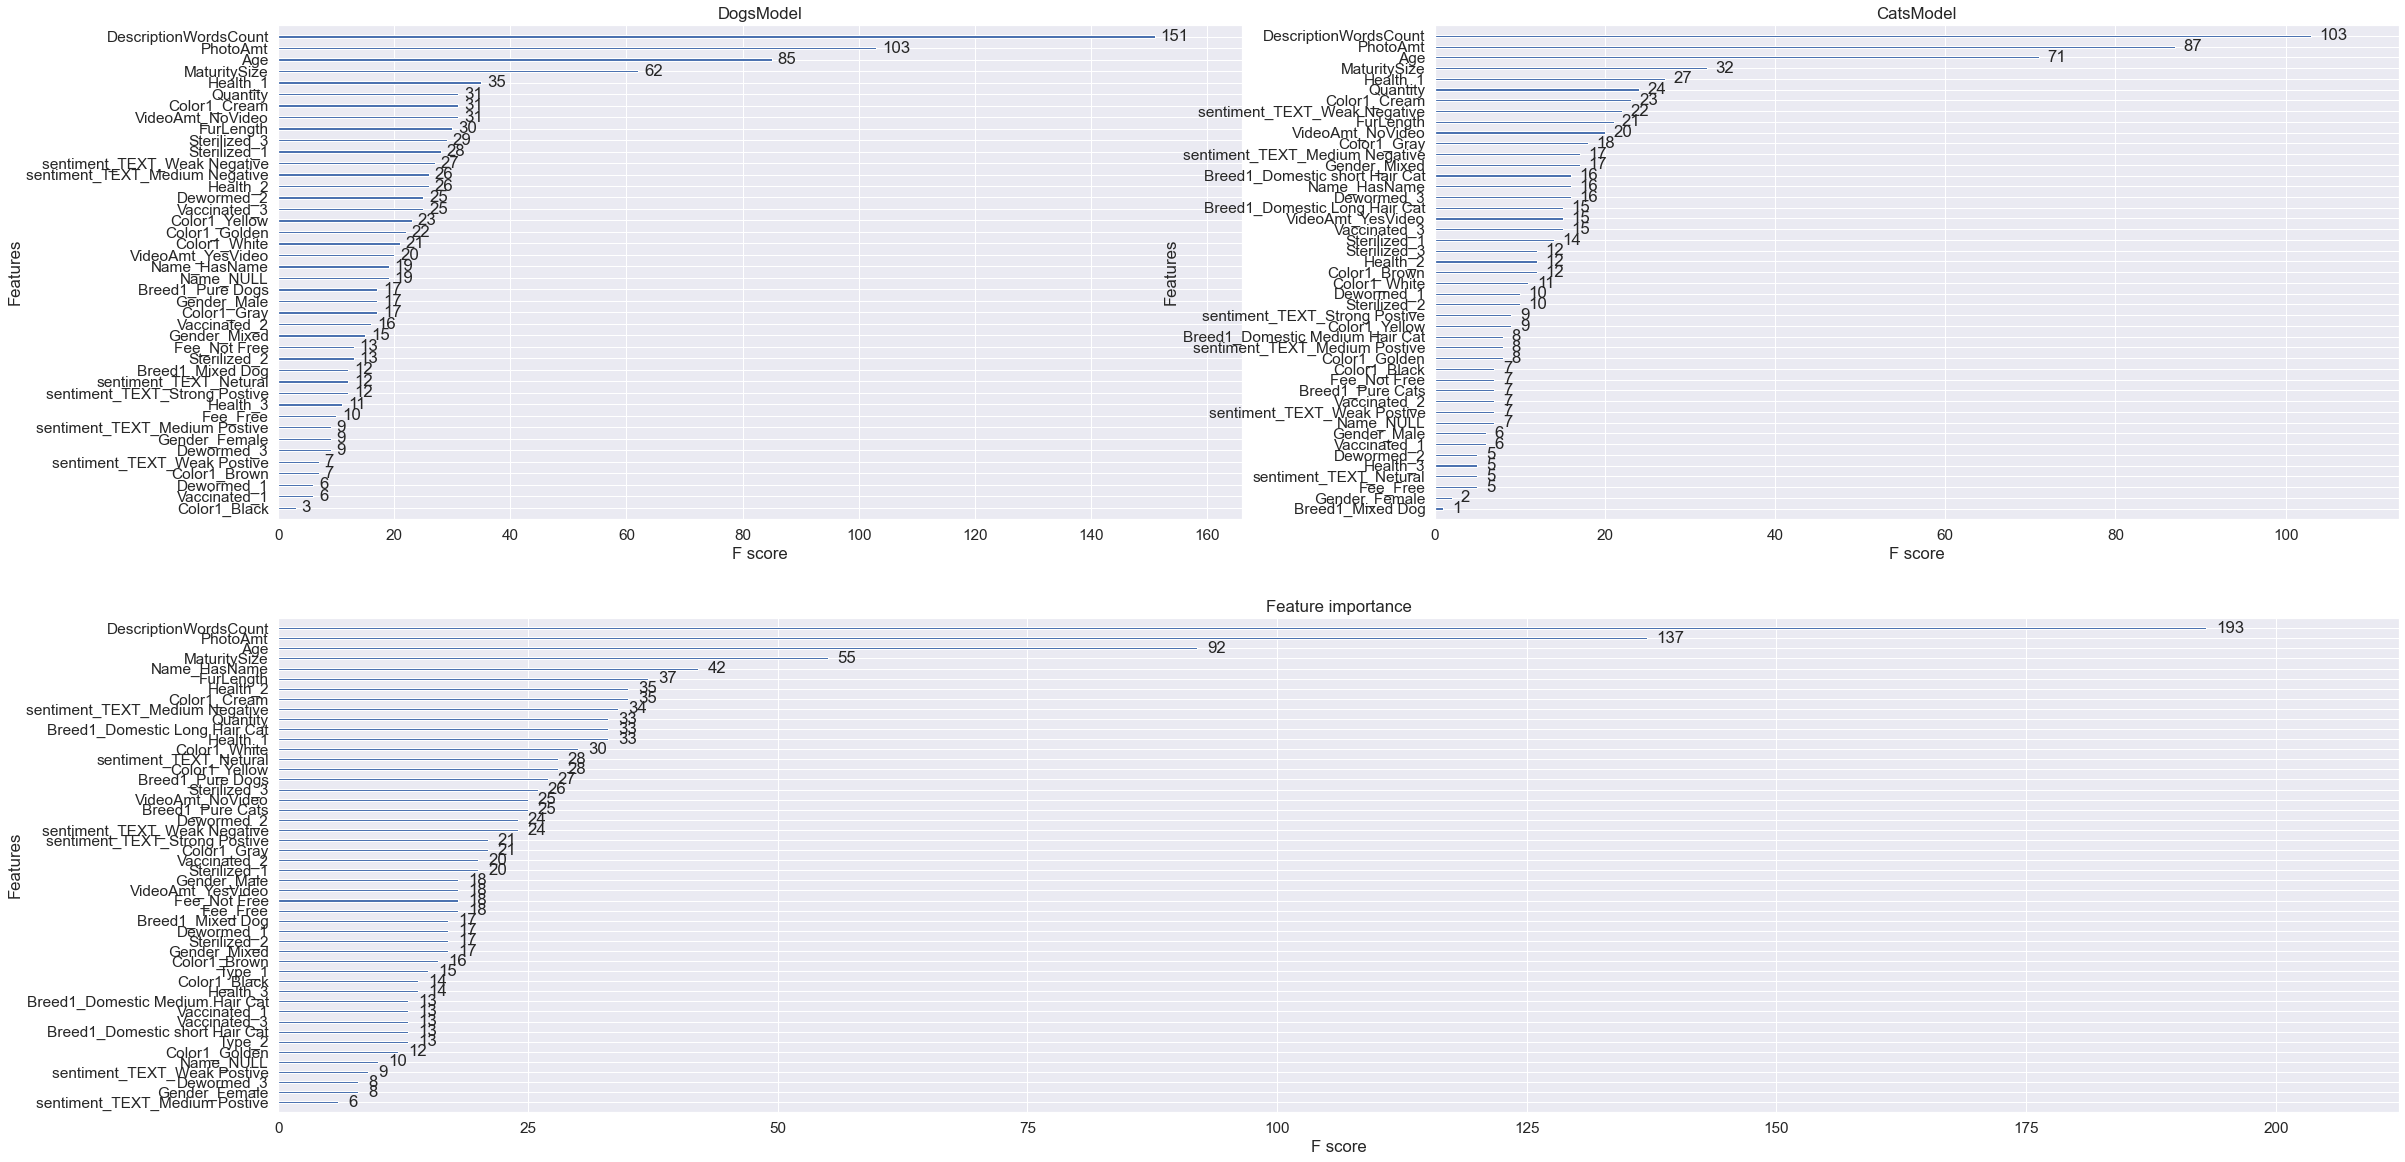

In [62]:
plt.figure(figsize=(38, 20));
ax2 = plt.subplot2grid((2, 2), (0, 0))
xgb.plot_importance(dogs_model,ax=ax2)

plt.title('DogsModel');

ax3 = plt.subplot2grid((2, 2), (0, 1))
xgb.plot_importance(cats_model,ax=ax3)
plt.title('CatsModel');

ax4 = plt.subplot2grid((2, 2), (1, 0),colspan=2)
plt.title('Combined');

xgb.plot_importance(model,ax=ax4);

- It seems Description count is a good feature.
- Photo Amount also and Age are important features as well.
- The difference between the combined model scores and separated model is not a lot, although, the combined model gave a better score.


**Adding more features**
Let's add the rescruer id and the name of pets and see if that works

In [63]:
train_dropped_df=df_train.copy()
train_dropped_df.drop(['Breed2', 'State','Color2','Color3'], axis=1, inplace=True)



test_dropped_df=test_df.copy()
test_dropped_df['Description']=test_dropped_df['Description'].fillna('').values
test_dropped_df['DescriptionWordsCount'] = test_dropped_df['Description'].apply(lambda x: len(x.split()))

test_dropped_df.drop(['Breed2', 'State','Color2','Color3',], axis=1, inplace=True)

train_cleaned_df=train_dropped_df.copy()
test_cleaned_df=test_dropped_df.copy()

#name
train_cleaned_df['Name'] =train_cleaned_df['Name'].fillna('NULL')
train_cleaned_df['Name'].replace({"No Name": "NULL", "No Name Yet": "NULL", "Unknown": "NULL", "Baby": "NULL","Lucky": "NULL","Brownie": "NULL","Blackie": "NULL","Puppy": "NULL","Kitty": "NULL","Kittens":"NULL"},inplace=True)
train_cleaned_df.loc[train_cleaned_df['Name'] !="NULL", 'Name'] = 'HasName'


test_cleaned_df['Name'] =test_cleaned_df['Name'].fillna('NULL')
test_cleaned_df['Name'].replace({"No Name": "NULL", "No Name Yet": "NULL", "Unknown": "NULL", "Baby": "NULL","Lucky": "NULL","Brownie": "NULL","Blackie": "NULL","Puppy": "NULL","Kitty": "NULL","Kittens":"NULL"},inplace=True)
test_cleaned_df.loc[test_cleaned_df['Name'] !="NULL", 'Name'] = 'HasName'
#Breed

a=df_train.copy()
counts = a['Breed1'].value_counts()
counts[counts>30] 
a=a[a['Breed1'].isin(counts[counts > 30].index)]
popbreeds=a['Breed1'].value_counts().index
    
    
train_cleaned_dogs=train_cleaned_df.loc[train_cleaned_df['Type']==1]
train_cleaned_cats=train_cleaned_df.loc[train_cleaned_df['Type']==2] 

train_cleaned_dogs.loc[~(train_cleaned_dogs['Breed1'].isin(popbreeds)),'Breed1'] ="Pure Dogs"
train_cleaned_cats.loc[~(train_cleaned_cats['Breed1'].isin(popbreeds)),'Breed1'] ="Pure Cats"

train_cleaned_df=train_cleaned_cats.append(train_cleaned_dogs)
train_cleaned_df.loc[(train_cleaned_df['Breed1']==307),'Breed1']='Mixed Dog'
train_cleaned_df.loc[(train_cleaned_df['Breed1']==266),'Breed1']='Domestic short Hair Cat'
train_cleaned_df.loc[(train_cleaned_df['Breed1']==265),'Breed1']='Domestic Medium Hair Cat'
train_cleaned_df.loc[(train_cleaned_df['Breed1']==264),'Breed1']='Domestic Long Hair Cat'
                                 #Test Breed
a=test_df.copy()
counts = a['Breed1'].value_counts()
counts[counts>30] 
a=a[a['Breed1'].isin(counts[counts > 30].index)]
popbreeds=a['Breed1'].value_counts().index
    
    
test_cleaned_dogs=test_cleaned_df.loc[test_cleaned_df['Type']==1]
test_cleaned_cats=test_cleaned_df.loc[test_cleaned_df['Type']==2] 

test_cleaned_dogs.loc[~(test_cleaned_dogs['Breed1'].isin(popbreeds)),'Breed1'] ="Pure Dogs"
test_cleaned_cats.loc[~(test_cleaned_cats['Breed1'].isin(popbreeds)),'Breed1'] ="Pure Cats"

test_cleaned_df=test_cleaned_cats.append(test_cleaned_cats)
test_cleaned_df.loc[(test_cleaned_df['Breed1']==307),'Breed1']='Mixed Dog'
test_cleaned_df.loc[(test_cleaned_df['Breed1']==266),'Breed1']='Domestic short Hair Cat'
test_cleaned_df.loc[(test_cleaned_df['Breed1']==265),'Breed1']='Domestic Medium Hair Cat'
test_cleaned_df.loc[(test_cleaned_df['Breed1']==264),'Breed1']='Domestic Long Hair Cat'  
                                 
#Gender
train_cleaned_df.loc[(train_cleaned_df['Gender']==1),'Gender']='Male'
train_cleaned_df.loc[(train_cleaned_df['Gender']==2),'Gender']='Female'
train_cleaned_df.loc[(train_cleaned_df['Gender']==3),'Gender']='Mixed'

test_cleaned_df.loc[(test_cleaned_df['Gender']==1),'Gender']='Male'
test_cleaned_df.loc[(test_cleaned_df['Gender']==2),'Gender']='Female'
test_cleaned_df.loc[(test_cleaned_df['Gender']==3),'Gender']='Mixed'

#colors
colors=["Nan","Black","Brown","Golden","Yellow","Cream","Gray","White"]

for i in range(1,8):
    train_cleaned_df.loc[(train_cleaned_df['Color1']==i),'Color1']=colors[i]
    
    
colors=["Nan","Black","Brown","Golden","Yellow","Cream","Gray","White"]

for i in range(1,8):
    test_cleaned_df.loc[(test_cleaned_df['Color1']==i),'Color1']=colors[i]

#fee
train_cleaned_df.loc[train_cleaned_df['Fee']>=1, 'Fee']='Paid'
train_cleaned_df.loc[train_cleaned_df['Fee']==0, 'Fee']='Free'

test_cleaned_df.loc[test_cleaned_df['Fee']>=1, 'Fee']='Paid'
test_cleaned_df.loc[test_cleaned_df['Fee']==0, 'Fee']='Free'
#videoamt
train_cleaned_df.loc[train_cleaned_df['VideoAmt']>=1, 'VideoAmt']='YesVideo'
train_cleaned_df.loc[train_cleaned_df['VideoAmt']==0, 'VideoAmt']='NoVideo'

test_cleaned_df.loc[test_cleaned_df['VideoAmt']>=1, 'VideoAmt']='YesVideo'
test_cleaned_df.loc[test_cleaned_df['VideoAmt']==0, 'VideoAmt']='NoVideo'


#RescuerID
# 2 is the sweet spot i will try 50 to reduce gridsearch time

a=df_train.copy()
counts = a['RescuerID'].value_counts()
counts[counts>2]
a=a[a['RescuerID'].isin(counts[counts > 2].index)]
poprescuers=a['RescuerID'].value_counts().index
    
    
train_cleaned_df.loc[~(train_cleaned_df['RescuerID'].isin(poprescuers)),'RescuerID'] ="less than 2 listings"

#RESUCER FOR TEST
a=test_df.copy()
counts = a['RescuerID'].value_counts()
counts[counts>2]
a=a[a['RescuerID'].isin(counts[counts > 2].index)]
poprescuers=a['RescuerID'].value_counts().index
    
    
test_cleaned_df.loc[~(test_cleaned_df['RescuerID'].isin(poprescuers)),'RescuerID'] ="less than 2 listings"

# Clean Outliers
train_cleaned_df=train_cleaned_df[(np.abs(stats.zscore(train_cleaned_df['Age'])) < 3)]
train_cleaned_df=train_cleaned_df[(np.abs(stats.zscore(train_cleaned_df['PhotoAmt'])) < 3)]
train_cleaned_df=train_cleaned_df[(np.abs(stats.zscore(train_cleaned_df['Quantity'])) < 3)]
train_cleaned_df=train_cleaned_df[(np.abs(stats.zscore(train_cleaned_df['DescriptionWordsCount'])) < 3)]




#dummies
train_cleaned_df['Type'] = pd.Categorical(train_cleaned_df.Type)
train_cleaned_df['Gender'] = pd.Categorical(train_cleaned_df.Gender)
train_cleaned_df['Vaccinated'] = pd.Categorical(train_cleaned_df.Vaccinated)
train_cleaned_df['Dewormed'] = pd.Categorical(train_cleaned_df.Dewormed)
train_cleaned_df['Sterilized'] = pd.Categorical(train_cleaned_df.Sterilized)
train_cleaned_df['Health'] = pd.Categorical(train_cleaned_df.Health)
train_cleaned_df['RescuerID'] = pd.Categorical(train_cleaned_df.RescuerID)

###################################
train_cleaned_df['sentiment_TEXT'] = pd.Categorical(train_cleaned_df.sentiment_TEXT)
###########################


train_cleaned_df=pd.get_dummies(train_cleaned_df,columns=['Type','Gender','Vaccinated','Dewormed','Sterilized','Health','RescuerID','sentiment_TEXT','Name', 'Breed1', 'Color1', 'Fee', 'VideoAmt'])
##################################
#test adding sentiment_text
test_sentiment_files = sorted(glob.glob('test_sentiment/*.json'))

print('num of train sentiment files: {}'.format(len(test_sentiment_files)))


data=[]

for i in range (len(test_sentiment_files)):
    with open(test_sentiment_files[i]) as jsonFile:
        jsonObject = json.load(jsonFile)
        jsonFile.close()
    score=jsonObject['documentSentiment']['score']
    magnitude=jsonObject['documentSentiment']['magnitude']
    path=test_sentiment_files[i]
    firstpos=path.rfind("/")
    lastpos=path.rfind(".")
    PetID=path[firstpos+1:lastpos]
    if score >=0.1:
        if magnitude < 2:
            data.append([PetID,'Weak Postive'])
        elif magnitude < 6 and magnitude>=2:
            data.append([PetID,'Medium Postive'])
        elif magnitude >=6:
            data.append([PetID,'Strong Postive'])
            
    elif score <=-0.1 :
        if magnitude < 2:
            data.append([PetID,'Weak Negative'])
        elif magnitude < 6 and magnitude>=2:
            data.append([PetID,'Medium Negative'])
        elif magnitude >=6:
            data.append([PetID,'Strong Negative'])
            
    else:
        data.append([PetID,'Netural'])


data = pd.DataFrame(data, columns=['PetID','sentiment_TEXT'])
test_cleaned_df=pd.merge(test_cleaned_df, data, on='PetID',how='outer')


##################################


#testdummies
test_cleaned_df['sentiment_TEXT'] = pd.Categorical(test_cleaned_df.sentiment_TEXT)
test_cleaned_df['Type'] = pd.Categorical(test_cleaned_df.Type)
test_cleaned_df['Gender'] = pd.Categorical(test_cleaned_df.Gender)
test_cleaned_df['Vaccinated'] = pd.Categorical(test_cleaned_df.Vaccinated)
test_cleaned_df['Dewormed'] = pd.Categorical(test_cleaned_df.Dewormed)
test_cleaned_df['Sterilized'] = pd.Categorical(test_cleaned_df.Sterilized)
test_cleaned_df['Health'] = pd.Categorical(test_cleaned_df.Health)
test_cleaned_df['RescuerID'] = pd.Categorical(test_cleaned_df.RescuerID)

test_cleaned_df=pd.get_dummies(test_cleaned_df,columns=['Type','Gender','Vaccinated','Dewormed','Sterilized','Health','RescuerID','sentiment_TEXT','Name', 'Breed1', 'Color1', 'Fee', 'VideoAmt'])


#Normalize
column_names_to_normalize = ['Age','MaturitySize','FurLength','Quantity','PhotoAmt','DescriptionWordsCount']
x = train_cleaned_df[column_names_to_normalize].values
scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = train_cleaned_df.index)
train_cleaned_df[column_names_to_normalize] = df_temp


column_names_to_normalize = ['Age','MaturitySize','FurLength','Quantity','PhotoAmt','DescriptionWordsCount']
x = test_cleaned_df[column_names_to_normalize].values
scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = test_cleaned_df.index)
test_cleaned_df[column_names_to_normalize] = df_temp


# DS train
train_data=train_cleaned_df.copy()
train_data = train_data.drop(['AdoptionSpeed'],axis=1)
train_target=train_cleaned_df.copy()
train_target = train_target['AdoptionSpeed']

# DS test
test_data=test_cleaned_df.copy()

#################

#dropping petID after copying it for ensemble_df
ensemble_df=train_cleaned_df.copy()
train_data.drop(['PetID','Description'], axis=1, inplace=True)
train_cleaned_df.drop(['PetID','Description'], axis=1, inplace=True)


test_data.drop(['PetID','Description'], axis=1, inplace=True)


num of train sentiment files: 3865


In [64]:
#modeling
dogs_train=train_cleaned_df[(train_cleaned_df['Type_1']==1)]
dogs_train=dogs_train.drop(['Type_2'],axis=1)
dogs_train=dogs_train.drop(['Type_1'],axis=1)

dogs_target=dogs_train['AdoptionSpeed']
dogs_train=dogs_train.drop(['AdoptionSpeed'],axis=1)

#Making a Cat DS
cats_train=train_cleaned_df[(train_cleaned_df['Type_1']==0)]
cats_train=cats_train.drop(['Type_2'],axis=1)
cats_train=cats_train.drop(['Type_1'],axis=1)

cats_target=cats_train['AdoptionSpeed']
cats_train=cats_train.drop(['AdoptionSpeed'],axis=1)
#combined model
data_dmatrix = xgb.DMatrix(data=train_data,label=train_target)
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.25, 
                                                    random_state=42,stratify=train_target)
# Cats and Dogs Models
datadogs_dmatrix = xgb.DMatrix(data=dogs_train,label=dogs_target)
datacats_dmatrix = xgb.DMatrix(data=cats_train,label=cats_target)

X_train_dogs, X_test_dogs, y_train_dogs, y_test_dogs = train_test_split(dogs_train, dogs_target, test_size=0.25,
                                                                        random_state=42,stratify=dogs_target)
X_train_cats, X_test_cats, y_train_cats, y_test_cats = train_test_split(cats_train, cats_target, test_size=0.25,
                                                                        random_state=42,stratify =cats_target)

model = XGBClassifier( colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 10, alpha = 20, n_estimators = 20,use_label_encoder =False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(quadratic_kappa(y_test, predictions))
dogsmodel = XGBClassifier( colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 10, alpha = 20, n_estimators = 20,use_label_encoder =False)
dogsmodel.fit(X_train_dogs, y_train_dogs)
y_pred_dogs = dogsmodel.predict(X_test_dogs)
predictions_dogs = [round(value) for value in y_pred_dogs]
accuracydogs = accuracy_score(y_test_dogs, predictions_dogs)
print('Dogs Model Details:')
print("Accuracy: %.2f%%" % (accuracydogs * 100.0))
print(f'Quadratic_kappa {quadratic_kappa(y_test_dogs, predictions_dogs)}')


catsmodel = XGBClassifier( colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 10, alpha = 20, n_estimators = 50,use_label_encoder =False)
catsmodel.fit(X_train_cats, y_train_cats)
y_pred_cats = catsmodel.predict(X_test_cats)
predictions_cats = [round(value) for value in y_pred_cats]
accuracycats = accuracy_score(y_test_cats, predictions_cats)
print('Cats Model Details:')
print("Accuracy: %.2f%%" % (accuracycats * 100.0))
print(f'Quadratic_kappa {quadratic_kappa(y_test_cats, predictions_cats)}')

print(tabulate([['CombinedModel', accuracy * 100.0,quadratic_kappa(y_test, predictions)],
                ['CatsModel', accuracycats * 100.0,quadratic_kappa(y_test_cats, predictions_cats)],
                ['DogsModel',accuracydogs * 100.0,quadratic_kappa(y_test_dogs, predictions_dogs)]],
               headers=['Model Name', 'Accuracy','Quadratic Kappa']))

[16:09:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 40.39%
0.3141411490897197
[16:09:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Dogs Model Details:
Accuracy: 44.99%
Quadratic_kappa 0.36303500854892523
[16:09:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XG

Again the combined model gives a better score. And this dataframe performs better than the previous one.

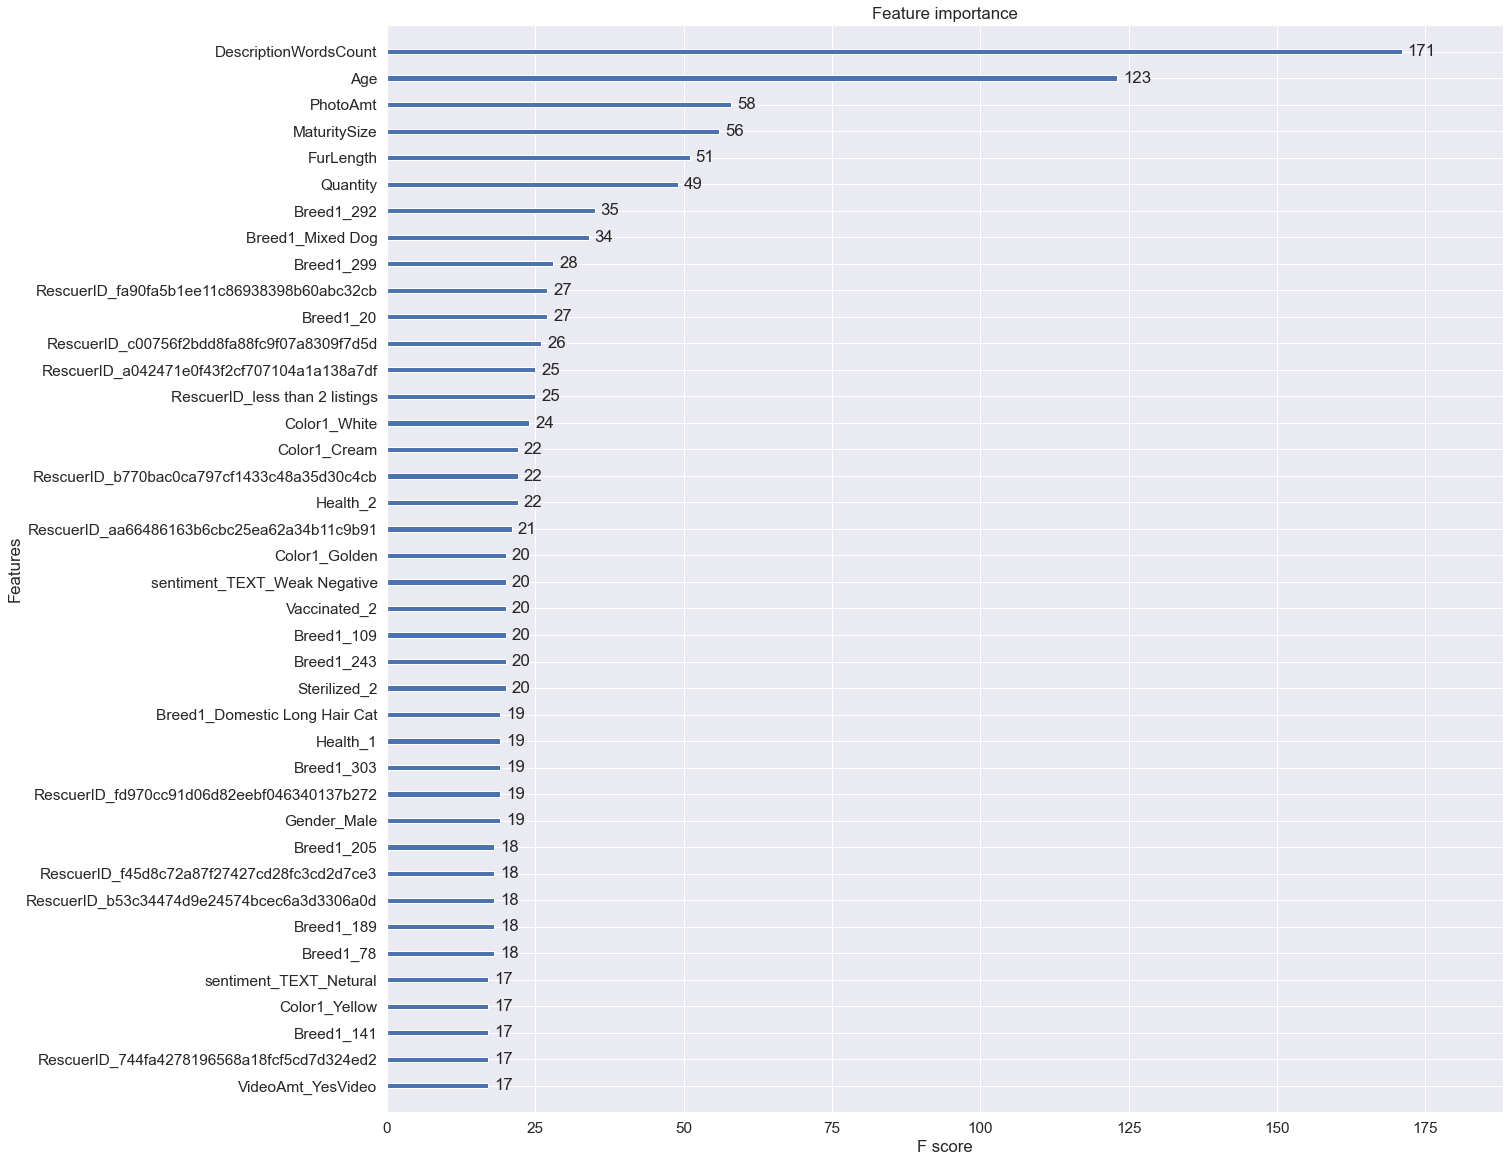

In [65]:
ax=xgb.plot_importance(model,max_num_features=40)
fig = ax.figure
fig.set_size_inches(20, 20)

Again Descriptionwordcount takes the lead, as well as age and maturity.
Some RescruerID weren't so important, so we will drop it.

The combined model still performs better, we will use the combined model technique for prediction.

In [71]:
final_train = train_df.copy()
final_test = test_df.copy()

final_test['Description']=final_test['Description'].fillna('').values
final_test['DescriptionWordsCount'] = final_test['Description'].apply(lambda x: len(x.split()))

In [73]:
cols_to_drop = ['Name','Breed2','Color3','Fee','RescuerID','Description','PetID']
final_train = final_train.drop(cols_to_drop,axis=1)
final_test = final_test.drop(cols_to_drop,axis=1)

In [78]:
cat_cols = ['Type', 'Age','Breed1','Gender', 'Color1', 'Color2',
       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'State']

In [79]:
%%time
indexer = {}
for col in cat_cols:
    # print(col)
    _, indexer[col] = pd.factorize(final_train[col].astype(str))
    
for col in tqdm_notebook(cat_cols):
    # print(col)
    final_train[col] = indexer[col].get_indexer(final_train[col].astype(str))
    final_test[col] = indexer[col].get_indexer(final_test[col].astype(str))

<timed exec>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CPU times: user 522 ms, sys: 43.9 ms, total: 565 ms
Wall time: 633 ms


In [80]:
y = final_train['AdoptionSpeed']
train = final_train.drop(['AdoptionSpeed'], axis=1)

In [81]:
final_test.shape

(3972, 17)

In [82]:
train.shape

(14993, 17)

In [83]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)

In [84]:
test = final_test.copy()

In [85]:
def train_model(X=train, X_test=test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    # Prepare data
    if make_oof:
        oof = np.zeros((len(X), 5))
    prediction = np.zeros((len(X_test), 5))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # LightGBM model
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature = cat_cols)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
             # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        # XGBoost model
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, 
                              num_boost_round=20000, 
                              evals=watchlist, 
                              early_stopping_rounds=200, 
                              verbose_eval=500, 
                              params=params)
            
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
            # feature importance
            fold_importance = pd.DataFrame(list(model.get_fscore().items()),columns=['feature','importance'])
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        # CatBoost model
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  loss_function='MultiClass',early_stopping_rounds = 200, **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test)
        
             # feature importance
            fold_importance = model.get_feature_importance(prettified=True).rename(columns={'Feature Id': 'feature', 'Importances': 'importance'})
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        if make_oof:
            oof[valid_index] = y_pred_valid
            
        scores.append(kappa(y_valid, y_pred_valid.argmax(1)))
        print('Fold kappa:', kappa(y_valid, y_pred_valid.argmax(1)))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
       
    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if plot_feature_importance: 
                 
        feature_importance["importance"] /= n_fold
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
             by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        
        if model_type == 'xgb':
            plt.title('XGB Features (avg over folds)');
        
        if model_type == 'lgb':
            plt.title('LGB Features (avg over folds)');
        
        if model_type == 'cat':
            plt.title('CAT Features (avg over folds)');
            
        result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict, scores , best_features

In [87]:
def kappa(y_true, y_pred):
    """Kappa score"""
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

Fold 1 started at Sat Oct 23 16:49:32 2021
[16:49:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.52326	valid_data-merror:0.65322
[500]	train-merror:0.24596	valid_data-merror:0.60287
[556]	train-merror:0.23103	valid_data-merror:0.60454
Fold kappa: 0.3032154663211941

Fold 2 started at Sat Oct 23 16:50:17 2021
[16:50:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pas

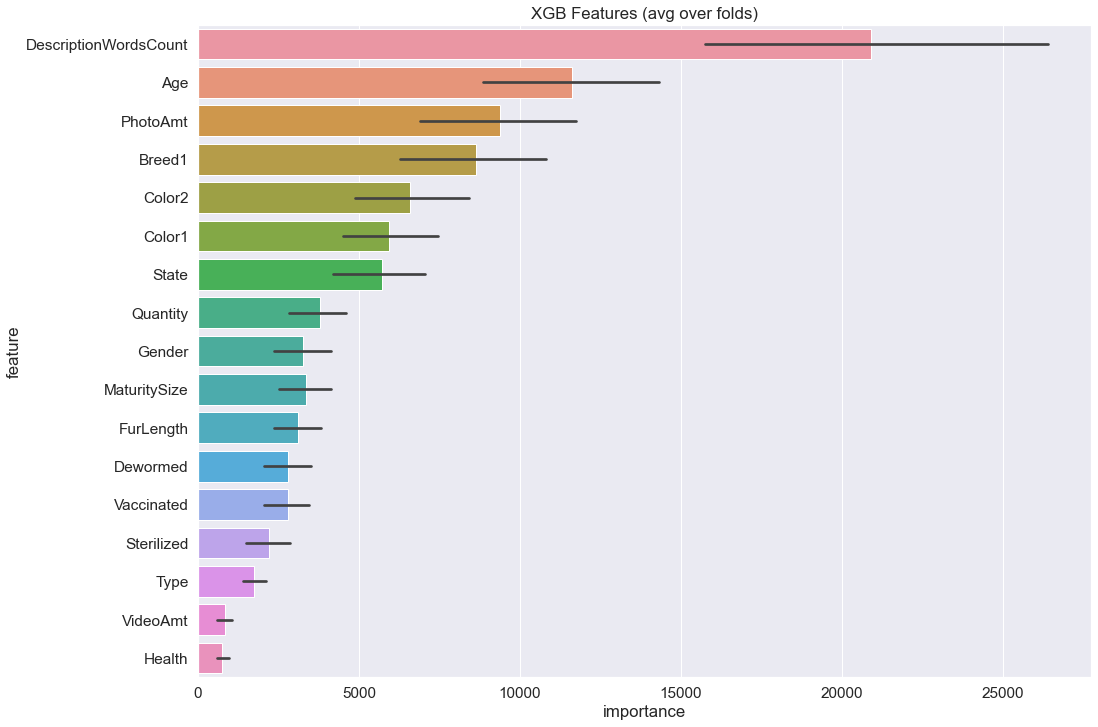

In [88]:
start = time.time()
xgb_params = {'eta': 0.01, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'multi:softprob', 'eval_metric': 'merror', 'silent': True, 'nthread': 4, 'num_class': 5}
result_dict_xgb, scores_xgb, best_features_xgb= train_model(X=train, X_test=test, y=y,params=xgb_params, model_type='xgb',plot_feature_importance=True, make_oof=True)
end = time.time()
time_spend_xgb = end - start
print(f'Time spend: {time_spend_xgb}')

In [89]:
best_features_xgb_top = best_features_xgb.loc[best_features_xgb['fold'] == 5].sort_values(by=['importance'], ascending=False)[:5].drop(['fold','importance'], axis=1).reset_index(drop=True)
best_features_xgb_top['model'] = 'XGBoost'
best_features_xgb_top

feature    model
0  DescriptionWordsCount  XGBoost
1                    Age  XGBoost
2               PhotoAmt  XGBoost
3                 Breed1  XGBoost
4                 Color2  XGBoost

In [90]:
final_score_xgb = pd.DataFrame([[np.mean(scores_xgb),np.std(scores_xgb),'XGBoost',time_spend_xgb]], 
                               columns=['mean','std','model','time_spend'])
final_score_xgb

mean       std    model  time_spend
0  0.332285  0.018582  XGBoost  241.865187

In [94]:
sub = pd.read_csv('test/sample_submission.csv')

In [96]:
prediction_xgb = (result_dict_xgb['prediction']).argmax(1)
submission_xgb = pd.DataFrame({'PetID': sub.PetID, 'AdoptionSpeed': [int(i) for i in prediction_xgb]})
submission_xgb.head()

PetID  AdoptionSpeed
0  e2dfc2935              4
1  f153b465f              1
2  3c90f3f54              2
3  e02abc8a3              4
4  09f0df7d1              4

In [97]:
submission_xgb.to_csv('submission.csv', index=False)

## Conclusion

The kappa score gave 0.34. 

At the same time, there can be more improvement done in the data. Like 